# Make feature importance

In [1]:
import shap
import matplotlib.pyplot as plt
# shap.initjs()
print(f'Shap version: {shap.__version__}') # 0.41.0

/home/yang_loci/miniconda3/envs/tandem/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Shap version: 0.41.0


IPython could not be loaded!


In [37]:
import os 
import sys
addpath = '/mnt/nas_1/YangLab/loci/tandem'
sys.path.append(addpath)
from src.utils.settings import TANDEM_R20000, CLUSTER, dynamics_feat, structure_feat, seq_feat, cols
from src.features import TANDEM_FEATS
from src.train.run import getR20000
import tensorflow as tf

sel_feats = TANDEM_FEATS['v0.2']
folds, R20000, preprocess_feat = getR20000(TANDEM_R20000, CLUSTER, feat_names=sel_feats)

model_path = '/mnt/nas_1/YangLab/loci/tandem/logs/final/different_number_of_layers/20250423-1234-tandem/n_hidden-5' #model_fold_1.h5'
models = [tf.keras.models.load_model(os.path.join(model_path, f'model_fold_{i}.h5')) for i in range(1, 6)]
testset = folds[0]['test']

ERROR:src.train.split_data:**************************************************
ERROR:src.train.split_data:Missing values in the dataframe:
ERROR:src.train.split_data:consurf: 		 2
ERROR:src.train.split_data:ACNR: 		 2
ERROR:src.train.split_data:deltaPSIC: 		 1
ERROR:src.train.split_data:SF1: 		 11
ERROR:src.train.split_data:SF2: 		 11
ERROR:src.train.split_data:SF3: 		 11
ERROR:src.train.split_data:entropy: 		 3769
ERROR:src.train.split_data:ranked_MI: 		 3769
ERROR:src.train.split_data:Assigning the mean value of feature to the missing values
ERROR:src.train.split_data:Assigning mean value to consurf: -0.23
ERROR:src.train.split_data:Assigning mean value to ACNR: -0.18
ERROR:src.train.split_data:Assigning mean value to deltaPSIC: 1.83
ERROR:src.train.split_data:Assigning mean value to SF1: 0.50
ERROR:src.train.split_data:Assigning mean value to SF2: 0.67
ERROR:src.train.split_data:Assigning mean value to SF3: 0.76
ERROR:src.train.split_data:Assigning mean value to entropy: 1.65
ERROR:s

In [38]:
import matplotlib.pyplot as pl
from matplotlib.colors import LinearSegmentedColormap
from shap.plots import colors
import numpy as np

def plot_figure_importance(shap_values, sel_feats, max_display=20, title='SHAP Summary Plot'):
    feature_names = [f'{cols[f]}' for f in sel_feats]
    feature_colors = [
        'lightcoral' if f in dynamics_feat else
        'skyblue' if f in structure_feat else
        'lightgreen' if f in seq_feat else
        'gray'  # optional default color if not found in any
        for f in sel_feats
    ]
    max_display = 10
    pl.figure(figsize=(5, 8))
        
    feature_order = np.argsort(np.sum(np.mean(np.abs(shap_values), axis=1), axis=0))
    feature_order = feature_order[-min(max_display, len(feature_order)):]
    
    class_names=['Benign', 'Pathogenic']
    feature_inds = feature_order[:max_display]
    
    # feature_rank = feature_names[feature_inds]
    feature_rank = [feature_names[i] for i in feature_inds]
    # Reverse the order of the feature_rank
    feature_rank = feature_rank[::-1]
    
    y_pos = np.arange(len(feature_inds))
    left_pos = np.zeros(len(feature_inds))
    # class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
    class_inds = [0, 1]
    
    show_values_in_legend = False
    if show_values_in_legend:
        # Get the smallest decimal place of the first significant digit
        # to print on the legend. The legend will print ('n_decimal'+1)
        # decimal places.
        # Set to 1 if the smallest number is bigger than 1.
        smallest_shap = np.min(np.abs(shap_values).mean((1, 2)))
        if smallest_shap > 1:
            n_decimals = 1
        else:
            n_decimals = int(-np.floor(
                np.log10(
                    smallest_shap
                )
            ))
    
    # set hatch for each class
    hatch = ['//', '']
    for i, ind in enumerate(class_inds):
        global_shap_values = np.abs(shap_values[ind]).mean(0)
        if show_values_in_legend:
            label = f'{class_names[ind]} ({np.round(np.mean(global_shap_values),(n_decimals+1))})'
        else:
            label = class_names[ind]
        pl.barh(
            y_pos, global_shap_values[feature_inds], 0.7, left=left_pos, align='center',
            # color=color(i), label=label,
            color='wheat',
            label=label,
            alpha=0.7,
            hatch=hatch[i]
        )
        left_pos += global_shap_values[feature_inds]
    
    pl.yticks(y_pos, fontsize=13)
    pl.gca().set_yticklabels([feature_names[i] for i in feature_inds])
    
    # Define color: DYN: red, SEQ: green, STR: blue
    # Now color the labels
    for ticklabel in plt.gca().get_yticklabels():
        text = ticklabel.get_text()
        if text in dynamics_feat.values():
            ticklabel.set_backgroundcolor('lightcoral')
        elif text in structure_feat.values():
            ticklabel.set_backgroundcolor('skyblue')
        elif text in seq_feat.values():
            ticklabel.set_backgroundcolor('lightgreen')
    pl.legend(frameon=False, fontsize=12)
    
    
    axis_color="#333333"
    pl.gca().xaxis.set_ticks_position('bottom')
    pl.gca().yaxis.set_ticks_position('none')
    pl.gca().spines['right'].set_visible(False)
    pl.gca().spines['top'].set_visible(False)
    pl.gca().spines['left'].set_visible(False)
    pl.gca().tick_params(color=axis_color, labelcolor=axis_color)
    pl.yticks(range(len(feature_order)), [feature_names[i] for i in feature_order], fontsize=15)
    
    pl.tight_layout()
    pl.title(title, fontsize=25)
    pl.show()
    return

### Split 1

In [39]:
import numpy as np
np.random.seed(1)
# Split 1
split = 0
background_0 = shap.kmeans(folds[split]['train']['x'], 100)
explainer_0 = shap.KernelExplainer(models[split].predict, background_0.data, link="logit")
shap_values_0 = explainer_0.shap_values(testset['x'], nsamples=100)
shap.summary_plot(shap_values_0, testset['x'], 
                  feature_names=sel_feats,
                  class_names=['Benign', 'Pathogenic'], 
                  plot_type='bar',max_display=10, color_bar=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/2043 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  0%|          | 1/2043 [00:00<15:04,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  0%|          | 2/2043 [00:00<15:41,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step


  0%|          | 3/2043 [00:01<15:58,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  0%|          | 4/2043 [00:01<16:04,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  0%|          | 5/2043 [00:02<16:11,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  0%|          | 6/2043 [00:02<16:06,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  0%|          | 7/2043 [00:03<16:13,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  0%|          | 8/2043 [00:03<16:12,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


  0%|          | 9/2043 [00:04<16:15,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  0%|          | 10/2043 [00:04<16:09,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  1%|          | 11/2043 [00:05<16:08,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  1%|          | 12/2043 [00:05<16:08,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


  1%|          | 13/2043 [00:06<16:08,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


  1%|          | 14/2043 [00:06<16:37,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step


  1%|          | 15/2043 [00:07<16:28,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  1%|          | 16/2043 [00:07<16:23,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step


  1%|          | 17/2043 [00:08<16:20,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  1%|          | 18/2043 [00:08<16:14,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  1%|          | 19/2043 [00:09<16:43,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  1%|          | 20/2043 [00:09<16:31,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  1%|          | 21/2043 [00:10<16:22,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  1%|          | 22/2043 [00:10<16:16,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  1%|          | 23/2043 [00:11<16:12,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  1%|          | 24/2043 [00:11<16:08,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  1%|          | 25/2043 [00:12<16:06,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  1%|▏         | 26/2043 [00:12<16:04,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  1%|▏         | 27/2043 [00:12<16:03,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  1%|▏         | 28/2043 [00:13<16:05,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  1%|▏         | 29/2043 [00:13<16:04,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  1%|▏         | 30/2043 [00:14<16:00,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


  2%|▏         | 31/2043 [00:14<16:04,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  2%|▏         | 32/2043 [00:15<16:05,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  2%|▏         | 33/2043 [00:15<16:02,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  2%|▏         | 34/2043 [00:16<16:00,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


  2%|▏         | 35/2043 [00:16<16:01,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  2%|▏         | 36/2043 [00:17<16:00,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  2%|▏         | 37/2043 [00:17<15:56,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  2%|▏         | 38/2043 [00:18<15:56,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  2%|▏         | 39/2043 [00:18<15:54,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  2%|▏         | 40/2043 [00:19<15:52,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  2%|▏         | 41/2043 [00:19<15:51,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  2%|▏         | 42/2043 [00:20<15:51,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  2%|▏         | 43/2043 [00:20<15:50,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  2%|▏         | 44/2043 [00:21<15:54,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  2%|▏         | 45/2043 [00:21<15:52,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


  2%|▏         | 46/2043 [00:22<15:52,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


  2%|▏         | 47/2043 [00:22<15:55,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  2%|▏         | 48/2043 [00:22<15:52,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  2%|▏         | 49/2043 [00:23<15:51,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  2%|▏         | 50/2043 [00:23<15:50,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  2%|▏         | 51/2043 [00:24<15:53,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  3%|▎         | 52/2043 [00:24<15:48,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


  3%|▎         | 53/2043 [00:25<15:52,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  3%|▎         | 54/2043 [00:25<15:56,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  3%|▎         | 55/2043 [00:26<15:53,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  3%|▎         | 56/2043 [00:26<15:50,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  3%|▎         | 57/2043 [00:27<15:51,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  3%|▎         | 58/2043 [00:27<15:46,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


  3%|▎         | 59/2043 [00:28<15:42,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  3%|▎         | 60/2043 [00:28<16:59,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step


  3%|▎         | 61/2043 [00:29<17:37,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  3%|▎         | 62/2043 [00:29<16:59,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  3%|▎         | 63/2043 [00:30<16:38,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  3%|▎         | 64/2043 [00:30<16:19,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  3%|▎         | 65/2043 [00:31<16:41,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  3%|▎         | 66/2043 [00:31<16:21,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  3%|▎         | 67/2043 [00:32<16:05,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  3%|▎         | 68/2043 [00:32<15:54,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  3%|▎         | 69/2043 [00:33<15:49,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


  3%|▎         | 70/2043 [00:33<15:44,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  3%|▎         | 71/2043 [00:34<15:42,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  4%|▎         | 72/2043 [00:34<15:38,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  4%|▎         | 73/2043 [00:35<16:09,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  4%|▎         | 74/2043 [00:35<15:55,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  4%|▎         | 75/2043 [00:36<15:47,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  4%|▎         | 76/2043 [00:36<15:41,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step


  4%|▍         | 77/2043 [00:37<15:41,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  4%|▍         | 78/2043 [00:37<15:35,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  4%|▍         | 79/2043 [00:38<15:32,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  4%|▍         | 80/2043 [00:38<15:28,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  4%|▍         | 81/2043 [00:39<15:30,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


  4%|▍         | 82/2043 [00:39<15:27,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


  4%|▍         | 83/2043 [00:39<15:28,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


  4%|▍         | 84/2043 [00:40<15:26,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  4%|▍         | 85/2043 [00:40<15:24,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


  4%|▍         | 86/2043 [00:41<15:22,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  4%|▍         | 87/2043 [00:41<15:21,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  4%|▍         | 88/2043 [00:42<15:18,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  4%|▍         | 89/2043 [00:42<15:20,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


  4%|▍         | 90/2043 [00:43<15:17,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  4%|▍         | 91/2043 [00:43<15:16,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  5%|▍         | 92/2043 [00:44<15:15,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  5%|▍         | 93/2043 [00:44<15:17,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  5%|▍         | 94/2043 [00:45<15:20,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  5%|▍         | 95/2043 [00:45<15:20,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  5%|▍         | 96/2043 [00:46<15:20,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  5%|▍         | 97/2043 [00:46<15:17,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  5%|▍         | 98/2043 [00:47<15:14,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  5%|▍         | 99/2043 [00:47<15:14,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


  5%|▍         | 100/2043 [00:47<15:13,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


  5%|▍         | 101/2043 [00:48<15:14,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  5%|▍         | 102/2043 [00:48<15:15,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  5%|▌         | 103/2043 [00:49<15:14,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


  5%|▌         | 104/2043 [00:49<15:12,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


  5%|▌         | 105/2043 [00:50<15:13,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  5%|▌         | 106/2043 [00:50<15:11,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


  5%|▌         | 107/2043 [00:51<15:09,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  5%|▌         | 108/2043 [00:51<15:10,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  5%|▌         | 109/2043 [00:52<15:09,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


  5%|▌         | 110/2043 [00:52<15:12,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  5%|▌         | 111/2043 [00:53<15:11,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


  5%|▌         | 112/2043 [00:53<15:11,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  6%|▌         | 113/2043 [00:54<15:10,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  6%|▌         | 114/2043 [00:54<15:07,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  6%|▌         | 115/2043 [00:55<15:05,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


  6%|▌         | 116/2043 [00:55<15:06,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


  6%|▌         | 117/2043 [00:55<15:06,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  6%|▌         | 118/2043 [00:56<15:05,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  6%|▌         | 119/2043 [00:56<15:06,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  6%|▌         | 120/2043 [00:57<15:05,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  6%|▌         | 121/2043 [00:57<15:04,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  6%|▌         | 122/2043 [00:58<15:04,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


  6%|▌         | 123/2043 [00:58<15:03,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  6%|▌         | 124/2043 [00:59<15:04,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  6%|▌         | 125/2043 [00:59<15:03,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  6%|▌         | 126/2043 [01:00<15:01,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  6%|▌         | 127/2043 [01:00<14:58,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  6%|▋         | 128/2043 [01:01<14:56,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  6%|▋         | 129/2043 [01:01<14:56,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  6%|▋         | 130/2043 [01:02<14:56,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  6%|▋         | 131/2043 [01:02<14:54,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  6%|▋         | 132/2043 [01:02<14:54,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  7%|▋         | 133/2043 [01:03<14:54,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  7%|▋         | 134/2043 [01:03<14:53,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  7%|▋         | 135/2043 [01:04<14:52,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  7%|▋         | 136/2043 [01:04<14:52,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  7%|▋         | 137/2043 [01:05<14:54,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  7%|▋         | 138/2043 [01:05<14:51,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  7%|▋         | 139/2043 [01:06<14:51,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


  7%|▋         | 140/2043 [01:06<15:09,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  7%|▋         | 141/2043 [01:07<15:06,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  7%|▋         | 142/2043 [01:07<15:01,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  7%|▋         | 143/2043 [01:08<14:57,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  7%|▋         | 144/2043 [01:08<14:52,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step


  7%|▋         | 145/2043 [01:09<14:56,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  7%|▋         | 146/2043 [01:09<14:53,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  7%|▋         | 147/2043 [01:10<14:50,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


  7%|▋         | 148/2043 [01:10<14:49,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  7%|▋         | 149/2043 [01:10<14:48,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  7%|▋         | 150/2043 [01:11<14:46,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


  7%|▋         | 151/2043 [01:12<15:31,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step


  7%|▋         | 152/2043 [01:12<16:15,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  7%|▋         | 153/2043 [01:13<15:49,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  8%|▊         | 154/2043 [01:13<15:28,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  8%|▊         | 155/2043 [01:13<15:13,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  8%|▊         | 156/2043 [01:14<15:02,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  8%|▊         | 157/2043 [01:14<14:55,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


  8%|▊         | 158/2043 [01:15<14:50,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  8%|▊         | 159/2043 [01:15<14:46,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  8%|▊         | 160/2043 [01:16<14:44,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  8%|▊         | 161/2043 [01:16<14:43,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  8%|▊         | 162/2043 [01:17<14:40,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  8%|▊         | 163/2043 [01:17<14:39,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  8%|▊         | 164/2043 [01:18<14:38,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  8%|▊         | 165/2043 [01:18<14:39,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  8%|▊         | 166/2043 [01:19<14:37,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  8%|▊         | 167/2043 [01:19<14:43,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step


  8%|▊         | 168/2043 [01:20<14:47,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  8%|▊         | 169/2043 [01:20<14:46,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  8%|▊         | 170/2043 [01:21<14:43,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  8%|▊         | 171/2043 [01:21<14:41,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  8%|▊         | 172/2043 [01:21<14:38,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  8%|▊         | 173/2043 [01:22<14:39,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  9%|▊         | 174/2043 [01:22<14:36,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  9%|▊         | 175/2043 [01:23<14:35,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  9%|▊         | 176/2043 [01:23<14:33,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  9%|▊         | 177/2043 [01:24<14:32,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  9%|▊         | 178/2043 [01:24<14:32,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


  9%|▉         | 179/2043 [01:25<14:32,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  9%|▉         | 180/2043 [01:25<14:32,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  9%|▉         | 181/2043 [01:26<14:32,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  9%|▉         | 182/2043 [01:26<14:31,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  9%|▉         | 183/2043 [01:27<14:30,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  9%|▉         | 184/2043 [01:27<14:30,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  9%|▉         | 185/2043 [01:28<14:32,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  9%|▉         | 186/2043 [01:28<14:29,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  9%|▉         | 187/2043 [01:28<14:28,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  9%|▉         | 188/2043 [01:29<14:28,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


  9%|▉         | 189/2043 [01:29<14:28,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  9%|▉         | 190/2043 [01:30<14:27,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  9%|▉         | 191/2043 [01:30<15:00,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  9%|▉         | 192/2043 [01:31<14:51,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  9%|▉         | 193/2043 [01:31<14:44,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  9%|▉         | 194/2043 [01:32<14:37,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 10%|▉         | 195/2043 [01:32<14:35,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 10%|▉         | 196/2043 [01:33<14:31,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 10%|▉         | 197/2043 [01:33<14:30,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


 10%|▉         | 198/2043 [01:34<14:29,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 10%|▉         | 199/2043 [01:34<14:25,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 10%|▉         | 200/2043 [01:35<14:23,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 10%|▉         | 201/2043 [01:35<14:21,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 10%|▉         | 202/2043 [01:36<14:20,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 10%|▉         | 203/2043 [01:36<14:20,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 10%|▉         | 204/2043 [01:37<14:19,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 10%|█         | 205/2043 [01:37<14:49,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 10%|█         | 206/2043 [01:37<14:38,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 10%|█         | 207/2043 [01:38<14:32,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 10%|█         | 208/2043 [01:38<14:28,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 10%|█         | 209/2043 [01:39<14:25,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


 10%|█         | 210/2043 [01:39<14:25,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 10%|█         | 211/2043 [01:40<14:23,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 10%|█         | 212/2043 [01:40<14:19,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 10%|█         | 213/2043 [01:41<14:20,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 10%|█         | 214/2043 [01:41<14:18,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 11%|█         | 215/2043 [01:42<14:16,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 11%|█         | 216/2043 [01:42<14:14,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


 11%|█         | 217/2043 [01:43<14:48,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


 11%|█         | 218/2043 [01:43<14:41,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 11%|█         | 219/2043 [01:44<14:33,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 11%|█         | 220/2043 [01:44<14:29,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 11%|█         | 221/2043 [01:45<14:22,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 11%|█         | 222/2043 [01:45<14:19,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 11%|█         | 223/2043 [01:46<14:18,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 11%|█         | 224/2043 [01:46<14:17,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 11%|█         | 225/2043 [01:46<14:14,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 11%|█         | 226/2043 [01:47<14:11,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 11%|█         | 227/2043 [01:47<14:10,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 11%|█         | 228/2043 [01:48<14:08,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 11%|█         | 229/2043 [01:48<14:11,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 11%|█▏        | 230/2043 [01:49<14:09,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 11%|█▏        | 231/2043 [01:49<14:09,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 11%|█▏        | 232/2043 [01:50<14:20,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 11%|█▏        | 233/2043 [01:50<14:46,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 11%|█▏        | 234/2043 [01:51<14:33,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 12%|█▏        | 235/2043 [01:51<14:22,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 12%|█▏        | 236/2043 [01:52<14:16,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 12%|█▏        | 237/2043 [01:52<14:16,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 12%|█▏        | 238/2043 [01:53<14:12,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


 12%|█▏        | 239/2043 [01:53<14:09,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 12%|█▏        | 240/2043 [01:54<14:07,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 12%|█▏        | 241/2043 [01:54<14:06,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 12%|█▏        | 242/2043 [01:54<14:04,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 12%|█▏        | 243/2043 [01:55<14:01,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 12%|█▏        | 244/2043 [01:55<13:59,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 12%|█▏        | 245/2043 [01:56<13:58,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 12%|█▏        | 246/2043 [01:56<14:00,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 12%|█▏        | 247/2043 [01:57<13:58,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step


 12%|█▏        | 248/2043 [01:57<14:20,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


 12%|█▏        | 249/2043 [01:58<15:25,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 12%|█▏        | 250/2043 [01:58<15:00,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 12%|█▏        | 251/2043 [01:59<14:39,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 12%|█▏        | 252/2043 [01:59<14:23,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 12%|█▏        | 253/2043 [02:00<14:15,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 12%|█▏        | 254/2043 [02:00<14:08,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 12%|█▏        | 255/2043 [02:01<14:31,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 13%|█▎        | 256/2043 [02:01<14:19,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 13%|█▎        | 257/2043 [02:02<14:09,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 13%|█▎        | 258/2043 [02:02<14:03,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step


 13%|█▎        | 259/2043 [02:03<14:05,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 13%|█▎        | 260/2043 [02:03<13:59,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 13%|█▎        | 261/2043 [02:04<13:55,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 13%|█▎        | 262/2043 [02:04<13:56,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 13%|█▎        | 263/2043 [02:05<13:52,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 13%|█▎        | 264/2043 [02:05<13:48,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 13%|█▎        | 265/2043 [02:05<13:45,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 13%|█▎        | 266/2043 [02:06<13:44,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 13%|█▎        | 267/2043 [02:06<13:45,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 13%|█▎        | 268/2043 [02:07<13:44,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


 13%|█▎        | 269/2043 [02:07<13:45,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 13%|█▎        | 270/2043 [02:08<13:44,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 13%|█▎        | 271/2043 [02:08<13:42,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 13%|█▎        | 272/2043 [02:09<13:42,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 13%|█▎        | 273/2043 [02:09<13:43,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 13%|█▎        | 274/2043 [02:10<13:42,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 13%|█▎        | 275/2043 [02:10<13:42,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 14%|█▎        | 276/2043 [02:11<13:41,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 14%|█▎        | 277/2043 [02:11<13:43,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 14%|█▎        | 278/2043 [02:11<13:45,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 14%|█▎        | 279/2043 [02:12<13:44,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 14%|█▎        | 280/2043 [02:12<13:45,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


 14%|█▍        | 281/2043 [02:13<14:20,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 14%|█▍        | 282/2043 [02:13<14:08,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 14%|█▍        | 283/2043 [02:14<13:59,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 14%|█▍        | 284/2043 [02:14<13:51,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 14%|█▍        | 285/2043 [02:15<13:51,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 14%|█▍        | 286/2043 [02:15<13:49,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 14%|█▍        | 287/2043 [02:16<13:48,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 14%|█▍        | 288/2043 [02:16<13:47,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 14%|█▍        | 289/2043 [02:17<13:48,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 14%|█▍        | 290/2043 [02:17<13:43,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 14%|█▍        | 291/2043 [02:18<13:40,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 14%|█▍        | 292/2043 [02:18<13:39,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 14%|█▍        | 293/2043 [02:19<13:37,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 14%|█▍        | 294/2043 [02:19<13:35,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 14%|█▍        | 295/2043 [02:20<13:33,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 14%|█▍        | 296/2043 [02:20<13:31,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 15%|█▍        | 297/2043 [02:20<13:31,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 15%|█▍        | 298/2043 [02:21<13:35,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 15%|█▍        | 299/2043 [02:21<13:32,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 15%|█▍        | 300/2043 [02:22<13:30,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 15%|█▍        | 301/2043 [02:22<13:31,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 15%|█▍        | 302/2043 [02:23<13:30,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 15%|█▍        | 303/2043 [02:23<13:30,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 15%|█▍        | 304/2043 [02:24<13:31,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


 15%|█▍        | 305/2043 [02:24<13:32,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 15%|█▍        | 306/2043 [02:25<13:34,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 15%|█▌        | 307/2043 [02:25<13:37,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 15%|█▌        | 308/2043 [02:26<13:32,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 15%|█▌        | 309/2043 [02:26<13:58,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 15%|█▌        | 310/2043 [02:27<13:48,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 15%|█▌        | 311/2043 [02:27<13:38,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 15%|█▌        | 312/2043 [02:27<13:32,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 15%|█▌        | 313/2043 [02:28<13:29,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 15%|█▌        | 314/2043 [02:28<13:27,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 15%|█▌        | 315/2043 [02:29<13:25,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 15%|█▌        | 316/2043 [02:29<13:23,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 16%|█▌        | 317/2043 [02:30<13:23,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 16%|█▌        | 318/2043 [02:30<13:50,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 16%|█▌        | 319/2043 [02:31<13:39,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 16%|█▌        | 320/2043 [02:31<13:35,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 16%|█▌        | 321/2043 [02:32<13:30,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 16%|█▌        | 322/2043 [02:32<13:29,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 16%|█▌        | 323/2043 [02:33<13:27,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 16%|█▌        | 324/2043 [02:33<13:23,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 16%|█▌        | 325/2043 [02:34<13:22,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 16%|█▌        | 326/2043 [02:34<13:20,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 16%|█▌        | 327/2043 [02:35<13:46,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 16%|█▌        | 328/2043 [02:35<13:39,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 16%|█▌        | 329/2043 [02:36<13:31,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 16%|█▌        | 330/2043 [02:36<13:29,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 16%|█▌        | 331/2043 [02:36<13:23,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 16%|█▋        | 332/2043 [02:37<13:18,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 16%|█▋        | 333/2043 [02:37<13:16,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 16%|█▋        | 334/2043 [02:38<13:17,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 16%|█▋        | 335/2043 [02:38<13:15,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 16%|█▋        | 336/2043 [02:39<13:24,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 16%|█▋        | 337/2043 [02:39<13:21,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 17%|█▋        | 338/2043 [02:40<13:18,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 17%|█▋        | 339/2043 [02:40<13:14,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 17%|█▋        | 340/2043 [02:41<13:12,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 17%|█▋        | 341/2043 [02:41<13:14,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 17%|█▋        | 342/2043 [02:42<13:16,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 17%|█▋        | 343/2043 [02:42<13:12,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 17%|█▋        | 344/2043 [02:43<13:10,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 17%|█▋        | 345/2043 [02:43<13:10,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step


 17%|█▋        | 346/2043 [02:43<13:35,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step


 17%|█▋        | 347/2043 [02:44<14:36,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 17%|█▋        | 348/2043 [02:45<14:07,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 17%|█▋        | 349/2043 [02:45<13:50,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 17%|█▋        | 350/2043 [02:45<13:36,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 17%|█▋        | 351/2043 [02:46<13:26,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 17%|█▋        | 352/2043 [02:46<13:18,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 17%|█▋        | 353/2043 [02:47<13:15,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 17%|█▋        | 354/2043 [02:47<13:11,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 17%|█▋        | 355/2043 [02:48<13:07,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 17%|█▋        | 356/2043 [02:48<13:05,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 17%|█▋        | 357/2043 [02:49<13:05,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 18%|█▊        | 358/2043 [02:49<13:04,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 18%|█▊        | 359/2043 [02:50<13:02,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 18%|█▊        | 360/2043 [02:50<13:01,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 18%|█▊        | 361/2043 [02:51<13:00,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 18%|█▊        | 362/2043 [02:51<13:01,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 18%|█▊        | 363/2043 [02:52<12:59,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 18%|█▊        | 364/2043 [02:52<12:58,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 18%|█▊        | 365/2043 [02:52<12:57,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 18%|█▊        | 366/2043 [02:53<12:57,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 18%|█▊        | 367/2043 [02:53<12:55,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 18%|█▊        | 368/2043 [02:54<12:55,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


 18%|█▊        | 369/2043 [02:54<12:57,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 18%|█▊        | 370/2043 [02:55<13:00,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 18%|█▊        | 371/2043 [02:55<12:58,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 18%|█▊        | 372/2043 [02:56<12:56,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 18%|█▊        | 373/2043 [02:56<12:56,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 18%|█▊        | 374/2043 [02:57<12:56,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 18%|█▊        | 375/2043 [02:57<12:56,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 18%|█▊        | 376/2043 [02:58<12:55,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 18%|█▊        | 377/2043 [02:58<12:54,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 19%|█▊        | 378/2043 [02:58<12:51,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 19%|█▊        | 379/2043 [02:59<12:51,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 30%|███       | 620/2043 [04:52<10:55,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 30%|███       | 621/2043 [04:52<10:55,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 30%|███       | 622/2043 [04:53<10:54,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 30%|███       | 623/2043 [04:53<10:53,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 31%|███       | 624/2043 [04:54<11:17,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 31%|███       | 625/2043 [04:54<11:10,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 31%|███       | 626/2043 [04:55<11:05,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 31%|███       | 627/2043 [04:55<11:00,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 31%|███       | 628/2043 [04:55<10:57,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 31%|███       | 629/2043 [04:56<11:01,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 31%|███       | 630/2043 [04:56<10:57,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 31%|███       | 631/2043 [04:57<10:55,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 31%|███       | 632/2043 [04:57<10:52,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 31%|███       | 633/2043 [04:58<10:51,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 31%|███       | 634/2043 [04:58<10:50,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 31%|███       | 635/2043 [04:59<10:48,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 31%|███       | 636/2043 [04:59<10:49,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 31%|███       | 637/2043 [05:00<10:49,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 31%|███       | 638/2043 [05:00<10:48,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 31%|███▏      | 639/2043 [05:01<10:50,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 31%|███▏      | 640/2043 [05:01<10:47,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 31%|███▏      | 641/2043 [05:01<10:47,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 31%|███▏      | 642/2043 [05:02<10:48,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 31%|███▏      | 643/2043 [05:02<10:47,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 32%|███▏      | 644/2043 [05:03<10:45,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 32%|███▏      | 645/2043 [05:03<10:45,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 32%|███▏      | 646/2043 [05:04<10:45,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 32%|███▏      | 647/2043 [05:04<10:44,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 32%|███▏      | 648/2043 [05:05<10:43,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 32%|███▏      | 649/2043 [05:05<10:42,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 32%|███▏      | 650/2043 [05:06<10:41,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 32%|███▏      | 651/2043 [05:06<10:40,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 32%|███▏      | 652/2043 [05:07<10:40,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 32%|███▏      | 653/2043 [05:07<10:40,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 32%|███▏      | 654/2043 [05:08<11:03,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 32%|███▏      | 655/2043 [05:08<10:55,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 32%|███▏      | 656/2043 [05:08<10:50,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 32%|███▏      | 657/2043 [05:09<10:45,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 32%|███▏      | 658/2043 [05:09<10:43,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 32%|███▏      | 659/2043 [05:10<10:41,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 32%|███▏      | 660/2043 [05:10<10:39,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 32%|███▏      | 661/2043 [05:11<10:40,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 32%|███▏      | 662/2043 [05:11<10:39,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 32%|███▏      | 663/2043 [05:12<10:36,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 33%|███▎      | 664/2043 [05:12<10:34,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 33%|███▎      | 665/2043 [05:13<10:58,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 33%|███▎      | 666/2043 [05:13<11:13,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 33%|███▎      | 667/2043 [05:14<11:01,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 33%|███▎      | 668/2043 [05:14<10:52,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


 33%|███▎      | 669/2043 [05:15<10:48,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 33%|███▎      | 670/2043 [05:15<10:43,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 33%|███▎      | 671/2043 [05:15<10:40,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 33%|███▎      | 672/2043 [05:16<10:35,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 33%|███▎      | 673/2043 [05:16<10:33,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 33%|███▎      | 674/2043 [05:17<10:32,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 33%|███▎      | 675/2043 [05:17<10:30,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 33%|███▎      | 676/2043 [05:18<10:32,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step


 33%|███▎      | 677/2043 [05:18<10:42,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 33%|███▎      | 678/2043 [05:19<10:37,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 33%|███▎      | 679/2043 [05:19<10:35,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 33%|███▎      | 680/2043 [05:20<10:33,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 33%|███▎      | 681/2043 [05:20<10:31,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 33%|███▎      | 682/2043 [05:21<10:29,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 33%|███▎      | 683/2043 [05:21<10:26,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 33%|███▎      | 684/2043 [05:21<10:24,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 34%|███▎      | 685/2043 [05:22<10:24,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 34%|███▎      | 686/2043 [05:22<10:25,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 34%|███▎      | 687/2043 [05:23<10:25,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 34%|███▎      | 688/2043 [05:23<10:23,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 34%|███▎      | 689/2043 [05:24<10:22,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 34%|███▍      | 690/2043 [05:24<10:22,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 34%|███▍      | 691/2043 [05:25<10:21,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 34%|███▍      | 692/2043 [05:25<10:21,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 34%|███▍      | 693/2043 [05:26<10:20,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 34%|███▍      | 694/2043 [05:26<10:20,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 34%|███▍      | 695/2043 [05:27<10:18,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 34%|███▍      | 696/2043 [05:27<10:18,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step


 34%|███▍      | 697/2043 [05:28<10:48,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step


 34%|███▍      | 698/2043 [05:28<11:21,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 34%|███▍      | 699/2043 [05:29<11:01,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 34%|███▍      | 700/2043 [05:29<10:46,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 34%|███▍      | 701/2043 [05:29<10:38,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 34%|███▍      | 702/2043 [05:30<10:31,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 34%|███▍      | 703/2043 [05:30<10:26,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 34%|███▍      | 704/2043 [05:31<10:20,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 35%|███▍      | 705/2043 [05:31<10:18,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 35%|███▍      | 706/2043 [05:32<10:16,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 35%|███▍      | 707/2043 [05:32<10:13,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 35%|███▍      | 708/2043 [05:33<10:12,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 35%|███▍      | 709/2043 [05:33<10:12,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 35%|███▍      | 710/2043 [05:34<10:11,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 35%|███▍      | 711/2043 [05:34<10:10,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


 35%|███▍      | 712/2043 [05:35<10:08,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 35%|███▍      | 713/2043 [05:35<10:08,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 35%|███▍      | 714/2043 [05:35<10:09,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 35%|███▍      | 715/2043 [05:36<10:08,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 35%|███▌      | 716/2043 [05:36<10:08,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 35%|███▌      | 717/2043 [05:37<10:08,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 35%|███▌      | 718/2043 [05:37<10:10,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 35%|███▌      | 719/2043 [05:38<10:08,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 35%|███▌      | 720/2043 [05:38<10:09,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 35%|███▌      | 721/2043 [05:39<10:07,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 35%|███▌      | 722/2043 [05:39<10:08,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 35%|███▌      | 723/2043 [05:40<10:08,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 35%|███▌      | 724/2043 [05:40<10:06,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 35%|███▌      | 725/2043 [05:40<10:05,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 36%|███▌      | 726/2043 [05:41<10:05,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 36%|███▌      | 727/2043 [05:41<10:04,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 36%|███▌      | 728/2043 [05:42<10:02,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 36%|███▌      | 729/2043 [05:42<10:01,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 36%|███▌      | 730/2043 [05:43<10:01,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 36%|███▌      | 731/2043 [05:43<10:01,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 36%|███▌      | 732/2043 [05:44<09:59,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 36%|███▌      | 733/2043 [05:44<09:59,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 36%|███▌      | 734/2043 [05:45<09:58,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 36%|███▌      | 735/2043 [05:45<09:57,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 36%|███▌      | 736/2043 [05:46<09:57,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 36%|███▌      | 737/2043 [05:46<09:57,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 36%|███▌      | 738/2043 [05:46<09:56,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 36%|███▌      | 739/2043 [05:47<09:56,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 36%|███▌      | 740/2043 [05:47<09:58,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 36%|███▋      | 741/2043 [05:48<09:57,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 36%|███▋      | 742/2043 [05:48<09:59,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 36%|███▋      | 743/2043 [05:49<09:57,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 36%|███▋      | 744/2043 [05:49<09:57,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 36%|███▋      | 745/2043 [05:50<09:57,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 37%|███▋      | 746/2043 [05:50<09:59,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 37%|███▋      | 747/2043 [05:51<09:56,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


 37%|███▋      | 748/2043 [05:51<09:54,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 37%|███▋      | 749/2043 [05:51<09:54,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 37%|███▋      | 750/2043 [05:52<09:54,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 37%|███▋      | 751/2043 [05:52<09:53,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 37%|███▋      | 752/2043 [05:53<09:52,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 37%|███▋      | 753/2043 [05:53<09:52,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 37%|███▋      | 754/2043 [05:54<09:51,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 37%|███▋      | 755/2043 [05:54<09:50,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 37%|███▋      | 756/2043 [05:55<09:50,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 37%|███▋      | 757/2043 [05:56<12:43,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 37%|███▋      | 758/2043 [05:56<11:55,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 37%|███▋      | 759/2043 [05:57<11:21,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 37%|███▋      | 760/2043 [05:57<10:58,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 37%|███▋      | 761/2043 [05:57<10:42,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


 37%|███▋      | 762/2043 [05:58<10:32,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 37%|███▋      | 763/2043 [05:58<10:25,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 37%|███▋      | 764/2043 [05:59<10:19,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 37%|███▋      | 765/2043 [05:59<10:14,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 37%|███▋      | 766/2043 [06:00<10:11,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 38%|███▊      | 767/2043 [06:00<10:08,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


 38%|███▊      | 768/2043 [06:01<10:09,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


 38%|███▊      | 769/2043 [06:01<10:07,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 38%|███▊      | 770/2043 [06:02<10:06,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


 38%|███▊      | 771/2043 [06:02<10:06,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 38%|███▊      | 772/2043 [06:03<10:05,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 38%|███▊      | 773/2043 [06:03<10:03,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 38%|███▊      | 774/2043 [06:04<10:02,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 38%|███▊      | 775/2043 [06:04<10:00,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 38%|███▊      | 776/2043 [06:05<10:09,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 38%|███▊      | 777/2043 [06:05<10:07,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


 38%|███▊      | 778/2043 [06:06<10:04,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 38%|███▊      | 779/2043 [06:06<10:03,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 38%|███▊      | 780/2043 [06:07<10:21,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 38%|███▊      | 781/2043 [06:07<10:13,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 38%|███▊      | 782/2043 [06:08<10:07,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 38%|███▊      | 783/2043 [06:08<10:06,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step


 38%|███▊      | 784/2043 [06:09<10:32,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step


 38%|███▊      | 785/2043 [06:09<10:59,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


 38%|███▊      | 786/2043 [06:10<10:40,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 39%|███▊      | 787/2043 [06:10<10:26,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


 39%|███▊      | 788/2043 [06:11<10:16,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 39%|███▊      | 789/2043 [06:11<10:09,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


 39%|███▊      | 790/2043 [06:12<10:05,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 39%|███▊      | 791/2043 [06:12<10:02,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 39%|███▉      | 792/2043 [06:12<09:58,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 39%|███▉      | 793/2043 [06:13<09:55,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


 39%|███▉      | 794/2043 [06:13<09:53,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 39%|███▉      | 795/2043 [06:14<09:53,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


 39%|███▉      | 796/2043 [06:14<09:53,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


 39%|███▉      | 797/2043 [06:15<09:51,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 39%|███▉      | 798/2043 [06:15<10:09,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 39%|███▉      | 799/2043 [06:16<10:23,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 39%|███▉      | 800/2043 [06:16<10:10,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 39%|███▉      | 801/2043 [06:17<10:02,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 39%|███▉      | 802/2043 [06:17<09:56,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 39%|███▉      | 803/2043 [06:18<09:52,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 39%|███▉      | 804/2043 [06:18<09:49,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 39%|███▉      | 805/2043 [06:19<09:47,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


 39%|███▉      | 806/2043 [06:19<09:46,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 40%|███▉      | 807/2043 [06:20<09:45,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


 40%|███▉      | 808/2043 [06:20<09:44,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 40%|███▉      | 809/2043 [06:21<09:42,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 40%|███▉      | 810/2043 [06:21<09:41,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 40%|███▉      | 811/2043 [06:22<09:41,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 40%|███▉      | 812/2043 [06:22<09:39,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 40%|███▉      | 813/2043 [06:22<09:40,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 40%|███▉      | 814/2043 [06:23<09:38,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


 40%|███▉      | 815/2043 [06:23<09:40,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 40%|███▉      | 816/2043 [06:24<09:39,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 40%|███▉      | 817/2043 [06:24<09:38,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


 40%|████      | 818/2043 [06:25<09:38,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 40%|████      | 819/2043 [06:25<09:38,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 40%|████      | 820/2043 [06:26<09:37,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 40%|████      | 821/2043 [06:26<09:35,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 40%|████      | 822/2043 [06:27<09:35,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


 40%|████      | 823/2043 [06:27<09:39,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 40%|████      | 824/2043 [06:28<09:37,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 40%|████      | 825/2043 [06:28<09:35,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 40%|████      | 826/2043 [06:29<09:33,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 40%|████      | 827/2043 [06:29<09:36,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 41%|████      | 828/2043 [06:30<09:33,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 41%|████      | 829/2043 [06:30<09:31,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


 41%|████      | 830/2043 [06:31<09:32,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


 41%|████      | 831/2043 [06:31<09:34,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 41%|████      | 832/2043 [06:31<09:32,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 41%|████      | 833/2043 [06:32<09:30,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


 41%|████      | 834/2043 [06:32<09:31,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


 41%|████      | 835/2043 [06:33<09:33,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 41%|████      | 836/2043 [06:33<09:32,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 41%|████      | 837/2043 [06:34<09:30,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


 41%|████      | 838/2043 [06:34<09:30,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 41%|████      | 839/2043 [06:35<09:31,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 41%|████      | 840/2043 [06:35<09:30,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 41%|████      | 841/2043 [06:36<09:29,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


 41%|████      | 842/2043 [06:36<09:29,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


 41%|████▏     | 843/2043 [06:37<09:30,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 41%|████▏     | 844/2043 [06:37<09:28,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 41%|████▏     | 845/2043 [06:38<09:27,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 41%|████▏     | 846/2043 [06:38<09:27,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


 41%|████▏     | 847/2043 [06:39<09:28,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 42%|████▏     | 848/2043 [06:39<09:26,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 42%|████▏     | 849/2043 [06:40<09:25,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 42%|████▏     | 850/2043 [06:40<09:25,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


 42%|████▏     | 851/2043 [06:40<09:27,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 42%|████▏     | 852/2043 [06:41<09:24,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 42%|████▏     | 853/2043 [06:41<09:22,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


 42%|████▏     | 854/2043 [06:42<09:23,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 42%|████▏     | 855/2043 [06:42<09:23,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 42%|████▏     | 856/2043 [06:43<09:21,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 42%|████▏     | 857/2043 [06:43<09:19,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step


 42%|████▏     | 858/2043 [06:44<09:23,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step


 42%|████▏     | 859/2043 [06:44<09:27,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 42%|████▏     | 860/2043 [06:45<09:24,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


 42%|████▏     | 861/2043 [06:45<09:22,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step


 42%|████▏     | 862/2043 [06:46<09:31,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 42%|████▏     | 863/2043 [06:46<09:29,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 42%|████▏     | 864/2043 [06:47<09:26,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


 42%|████▏     | 865/2043 [06:47<09:23,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


 42%|████▏     | 866/2043 [06:48<09:22,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


 42%|████▏     | 867/2043 [06:48<09:21,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 42%|████▏     | 868/2043 [06:49<09:19,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 43%|████▎     | 869/2043 [06:49<09:31,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step


 43%|████▎     | 870/2043 [06:50<09:41,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


 43%|████▎     | 871/2043 [06:50<10:06,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 43%|████▎     | 872/2043 [06:51<09:49,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 43%|████▎     | 873/2043 [06:51<09:37,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 43%|████▎     | 874/2043 [06:52<09:29,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 43%|████▎     | 875/2043 [06:52<09:24,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 43%|████▎     | 876/2043 [06:53<09:20,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 43%|████▎     | 877/2043 [06:53<09:17,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 43%|████▎     | 878/2043 [06:53<09:14,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 43%|████▎     | 879/2043 [06:54<09:13,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 43%|████▎     | 880/2043 [06:54<09:12,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


 43%|████▎     | 881/2043 [06:55<09:12,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 43%|████▎     | 882/2043 [06:55<09:10,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 43%|████▎     | 883/2043 [06:56<09:09,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 43%|████▎     | 884/2043 [06:56<09:08,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 43%|████▎     | 885/2043 [06:57<09:07,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 43%|████▎     | 886/2043 [06:57<09:06,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 43%|████▎     | 887/2043 [06:58<09:06,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 43%|████▎     | 888/2043 [06:58<09:06,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 44%|████▎     | 889/2043 [06:59<09:05,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 44%|████▎     | 890/2043 [06:59<09:04,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 44%|████▎     | 891/2043 [07:00<09:04,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 44%|████▎     | 892/2043 [07:00<09:02,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 44%|████▎     | 893/2043 [07:01<09:02,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 44%|████▍     | 894/2043 [07:01<09:01,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 44%|████▍     | 895/2043 [07:02<09:02,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 44%|████▍     | 896/2043 [07:02<09:00,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 44%|████▍     | 897/2043 [07:02<08:58,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 44%|████▍     | 898/2043 [07:03<08:57,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 44%|████▍     | 899/2043 [07:03<08:57,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 44%|████▍     | 900/2043 [07:04<08:57,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 44%|████▍     | 901/2043 [07:04<08:57,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 44%|████▍     | 902/2043 [07:05<08:58,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


 44%|████▍     | 903/2043 [07:05<09:16,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 44%|████▍     | 904/2043 [07:06<09:08,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 44%|████▍     | 905/2043 [07:06<09:03,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 44%|████▍     | 906/2043 [07:07<09:00,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 44%|████▍     | 907/2043 [07:07<08:59,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 44%|████▍     | 908/2043 [07:08<08:56,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 44%|████▍     | 909/2043 [07:08<08:55,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 45%|████▍     | 910/2043 [07:09<08:53,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 45%|████▍     | 911/2043 [07:09<08:56,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 45%|████▍     | 912/2043 [07:10<08:53,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 45%|████▍     | 913/2043 [07:10<08:52,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 45%|████▍     | 914/2043 [07:11<08:53,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 45%|████▍     | 915/2043 [07:11<09:11,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 45%|████▍     | 916/2043 [07:12<09:04,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 45%|████▍     | 917/2043 [07:12<08:59,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 45%|████▍     | 918/2043 [07:13<09:13,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 45%|████▍     | 919/2043 [07:13<09:17,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 45%|████▌     | 920/2043 [07:13<09:07,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 45%|████▌     | 921/2043 [07:14<09:01,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 45%|████▌     | 922/2043 [07:14<09:14,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 45%|████▌     | 923/2043 [07:15<09:05,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 45%|████▌     | 924/2043 [07:15<08:59,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step


 45%|████▌     | 925/2043 [07:16<08:56,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 45%|████▌     | 926/2043 [07:16<08:53,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 45%|████▌     | 927/2043 [07:17<08:50,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 45%|████▌     | 928/2043 [07:17<08:47,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 45%|████▌     | 929/2043 [07:18<08:45,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 46%|████▌     | 930/2043 [07:18<08:44,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 46%|████▌     | 931/2043 [07:19<08:44,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 46%|████▌     | 932/2043 [07:19<08:43,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


 46%|████▌     | 933/2043 [07:20<08:43,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 46%|████▌     | 934/2043 [07:20<08:42,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 46%|████▌     | 935/2043 [07:21<08:41,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 46%|████▌     | 936/2043 [07:21<08:40,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 46%|████▌     | 937/2043 [07:22<08:40,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 46%|████▌     | 938/2043 [07:22<08:40,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 46%|████▌     | 939/2043 [07:22<08:39,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 46%|████▌     | 940/2043 [07:23<08:37,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 46%|████▌     | 941/2043 [07:23<08:36,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 46%|████▌     | 942/2043 [07:24<08:36,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 46%|████▌     | 943/2043 [07:24<08:36,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 46%|████▌     | 944/2043 [07:25<08:35,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 46%|████▋     | 945/2043 [07:25<08:34,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 46%|████▋     | 946/2043 [07:26<08:34,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 46%|████▋     | 947/2043 [07:26<08:34,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 46%|████▋     | 948/2043 [07:27<08:33,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 46%|████▋     | 949/2043 [07:27<08:34,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 47%|████▋     | 950/2043 [07:28<08:55,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step


 47%|████▋     | 951/2043 [07:28<09:02,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


 47%|████▋     | 952/2043 [07:29<09:25,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


 47%|████▋     | 953/2043 [07:29<09:08,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 47%|████▋     | 954/2043 [07:30<09:13,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 47%|████▋     | 955/2043 [07:30<09:01,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 47%|████▋     | 956/2043 [07:31<08:50,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 47%|████▋     | 957/2043 [07:31<08:42,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 47%|████▋     | 958/2043 [07:32<08:36,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


 47%|████▋     | 959/2043 [07:32<08:35,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 47%|████▋     | 960/2043 [07:33<08:31,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 47%|████▋     | 961/2043 [07:33<08:29,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 47%|████▋     | 962/2043 [07:34<08:27,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 47%|████▋     | 963/2043 [07:34<08:25,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 47%|████▋     | 964/2043 [07:34<08:24,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 47%|████▋     | 965/2043 [07:35<08:23,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 47%|████▋     | 966/2043 [07:35<08:23,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 47%|████▋     | 967/2043 [07:36<08:23,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 47%|████▋     | 968/2043 [07:36<08:41,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


 47%|████▋     | 969/2043 [07:37<08:53,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 47%|████▋     | 970/2043 [07:37<08:43,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step


 48%|████▊     | 971/2043 [07:38<08:41,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


 48%|████▊     | 972/2043 [07:38<08:37,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 48%|████▊     | 973/2043 [07:39<08:32,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 48%|████▊     | 974/2043 [07:39<08:27,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 48%|████▊     | 975/2043 [07:40<08:26,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 48%|████▊     | 976/2043 [07:40<08:25,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


 48%|████▊     | 977/2043 [07:41<08:23,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 48%|████▊     | 978/2043 [07:41<08:21,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 48%|████▊     | 979/2043 [07:42<08:22,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 48%|████▊     | 980/2043 [07:42<08:20,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 48%|████▊     | 981/2043 [07:43<08:20,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 48%|████▊     | 982/2043 [07:43<08:18,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 48%|████▊     | 983/2043 [07:44<08:34,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


 48%|████▊     | 984/2043 [07:44<08:28,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 48%|████▊     | 985/2043 [07:44<08:23,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 48%|████▊     | 986/2043 [07:45<08:20,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 48%|████▊     | 987/2043 [07:45<08:35,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 48%|████▊     | 988/2043 [07:46<08:27,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 48%|████▊     | 989/2043 [07:46<08:21,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 48%|████▊     | 990/2043 [07:47<08:18,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 49%|████▊     | 991/2043 [07:47<08:33,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 49%|████▊     | 992/2043 [07:48<08:26,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 49%|████▊     | 993/2043 [07:48<08:19,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
 90/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



### Split 2

In [40]:
np.random.seed(1)
# Split 1
split = 1
background_1 = shap.kmeans(folds[split]['train']['x'], 100)
explainer_1 = shap.KernelExplainer(models[split].predict, background_1.data, link="logit")
shap_values_1 = explainer_1.shap_values(testset['x'], nsamples=100)
shap.summary_plot(shap_values_1, testset['x'], 
                  feature_names=sel_feats,
                  class_names=['Benign', 'Pathogenic'], 
                  plot_type='bar',max_display=10, color_bar=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/2043 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  0%|          | 1/2043 [00:00<14:43,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  0%|          | 2/2043 [00:00<15:16,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  0%|          | 3/2043 [00:01<16:20,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  0%|          | 4/2043 [00:01<16:04,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


  0%|          | 5/2043 [00:02<15:59,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


  0%|          | 6/2043 [00:02<15:52,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step


  0%|          | 7/2043 [00:03<16:40,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


  0%|          | 8/2043 [00:03<17:21,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step


  0%|          | 9/2043 [00:04<16:50,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step


  0%|          | 10/2043 [00:04<16:28,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  1%|          | 11/2043 [00:05<16:16,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  1%|          | 12/2043 [00:05<16:04,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  1%|          | 13/2043 [00:06<15:58,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  1%|          | 14/2043 [00:06<15:51,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


  1%|          | 15/2043 [00:07<15:49,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step


  1%|          | 16/2043 [00:07<15:47,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  1%|          | 17/2043 [00:08<16:16,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  1%|          | 18/2043 [00:08<16:02,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  1%|          | 19/2043 [00:09<15:56,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  1%|          | 20/2043 [00:09<15:50,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  1%|          | 21/2043 [00:09<15:46,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  1%|          | 22/2043 [00:10<15:41,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


  1%|          | 23/2043 [00:10<15:42,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  1%|          | 24/2043 [00:11<15:40,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  1%|          | 25/2043 [00:11<15:38,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  1%|▏         | 26/2043 [00:12<15:35,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step


  1%|▏         | 27/2043 [00:12<15:36,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


  1%|▏         | 28/2043 [00:13<15:35,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  1%|▏         | 29/2043 [00:13<15:33,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  1%|▏         | 30/2043 [00:14<15:31,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step


  2%|▏         | 31/2043 [00:14<15:33,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step


  2%|▏         | 32/2043 [00:15<16:03,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


  2%|▏         | 33/2043 [00:15<16:25,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


  2%|▏         | 34/2043 [00:16<16:09,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step


  2%|▏         | 35/2043 [00:16<15:59,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  2%|▏         | 36/2043 [00:17<15:50,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step


  2%|▏         | 37/2043 [00:17<15:43,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  2%|▏         | 38/2043 [00:17<15:38,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  2%|▏         | 39/2043 [00:18<15:38,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  2%|▏         | 40/2043 [00:18<15:35,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  2%|▏         | 41/2043 [00:19<15:33,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step


  2%|▏         | 42/2043 [00:19<15:31,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


  2%|▏         | 43/2043 [00:20<15:33,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


  2%|▏         | 44/2043 [00:20<15:32,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  2%|▏         | 45/2043 [00:21<15:29,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  2%|▏         | 46/2043 [00:21<15:25,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  2%|▏         | 47/2043 [00:22<15:26,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


  2%|▏         | 48/2043 [00:22<15:56,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  2%|▏         | 49/2043 [00:23<15:46,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


  2%|▏         | 50/2043 [00:23<15:39,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


  2%|▏         | 51/2043 [00:24<15:38,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  3%|▎         | 52/2043 [00:24<15:36,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  3%|▎         | 53/2043 [00:25<15:33,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  3%|▎         | 54/2043 [00:25<15:28,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


  3%|▎         | 55/2043 [00:25<15:29,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step


  3%|▎         | 56/2043 [00:26<15:31,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  3%|▎         | 57/2043 [00:26<15:27,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


  3%|▎         | 58/2043 [00:27<15:23,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  3%|▎         | 59/2043 [00:27<15:21,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  3%|▎         | 60/2043 [00:28<15:19,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  3%|▎         | 61/2043 [00:28<15:17,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  3%|▎         | 62/2043 [00:29<15:18,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  3%|▎         | 63/2043 [00:29<15:15,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  3%|▎         | 64/2043 [00:30<15:12,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  3%|▎         | 65/2043 [00:30<15:09,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  3%|▎         | 66/2043 [00:31<15:09,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  3%|▎         | 67/2043 [00:31<15:12,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  3%|▎         | 68/2043 [00:31<15:09,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  3%|▎         | 69/2043 [00:32<15:06,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  3%|▎         | 70/2043 [00:32<15:07,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  3%|▎         | 71/2043 [00:33<15:08,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


  4%|▎         | 72/2043 [00:33<15:09,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


  4%|▎         | 73/2043 [00:34<15:07,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  4%|▎         | 74/2043 [00:34<15:05,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  4%|▎         | 75/2043 [00:35<15:10,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step


  4%|▎         | 76/2043 [00:35<15:41,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step


  4%|▍         | 77/2043 [00:36<16:36,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step


  4%|▍         | 78/2043 [00:36<17:12,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  4%|▍         | 79/2043 [00:37<16:39,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  4%|▍         | 80/2043 [00:37<16:09,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  4%|▍         | 81/2043 [00:38<15:48,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


  4%|▍         | 82/2043 [00:38<15:34,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  4%|▍         | 83/2043 [00:39<15:27,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


  4%|▍         | 84/2043 [00:39<15:15,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  4%|▍         | 85/2043 [00:40<15:10,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  4%|▍         | 86/2043 [00:40<15:39,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  4%|▍         | 87/2043 [00:41<15:28,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  4%|▍         | 88/2043 [00:41<15:18,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  4%|▍         | 89/2043 [00:42<15:44,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


  4%|▍         | 90/2043 [00:42<15:28,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  4%|▍         | 91/2043 [00:42<15:20,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  5%|▍         | 92/2043 [00:43<15:12,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  5%|▍         | 93/2043 [00:43<15:08,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  5%|▍         | 94/2043 [00:44<15:03,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  5%|▍         | 95/2043 [00:44<15:02,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  5%|▍         | 96/2043 [00:45<14:59,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  5%|▍         | 97/2043 [00:45<14:57,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  5%|▍         | 98/2043 [00:46<14:56,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  5%|▍         | 99/2043 [00:46<14:58,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  5%|▍         | 100/2043 [00:47<14:56,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  5%|▍         | 101/2043 [00:47<15:27,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  5%|▍         | 102/2043 [00:48<15:18,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


  5%|▌         | 103/2043 [00:48<15:11,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


  5%|▌         | 104/2043 [00:48<15:04,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  5%|▌         | 105/2043 [00:49<14:58,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  5%|▌         | 106/2043 [00:49<14:56,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  5%|▌         | 107/2043 [00:50<14:54,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  5%|▌         | 108/2043 [00:50<15:26,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  5%|▌         | 109/2043 [00:51<15:13,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  5%|▌         | 110/2043 [00:51<15:05,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step


  5%|▌         | 111/2043 [00:52<15:02,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


  5%|▌         | 112/2043 [00:52<15:01,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  6%|▌         | 113/2043 [00:53<14:58,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


  6%|▌         | 114/2043 [00:53<14:56,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  6%|▌         | 115/2043 [00:54<14:56,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  6%|▌         | 116/2043 [00:54<14:55,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  6%|▌         | 117/2043 [00:55<15:25,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  6%|▌         | 118/2043 [00:55<15:45,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step


  6%|▌         | 119/2043 [00:56<16:04,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


  6%|▌         | 120/2043 [00:56<15:44,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  6%|▌         | 121/2043 [00:57<15:27,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  6%|▌         | 122/2043 [00:57<15:14,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


  6%|▌         | 123/2043 [00:57<15:08,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  6%|▌         | 124/2043 [00:58<15:00,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  6%|▌         | 125/2043 [00:58<14:52,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  6%|▌         | 126/2043 [00:59<14:47,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  6%|▌         | 127/2043 [00:59<14:46,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  6%|▋         | 128/2043 [01:00<14:43,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


  6%|▋         | 129/2043 [01:00<14:42,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  6%|▋         | 130/2043 [01:01<14:39,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  6%|▋         | 131/2043 [01:01<14:41,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


  6%|▋         | 132/2043 [01:02<14:40,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  7%|▋         | 133/2043 [01:02<14:39,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  7%|▋         | 134/2043 [01:03<14:36,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  7%|▋         | 135/2043 [01:03<14:36,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


  7%|▋         | 136/2043 [01:03<14:34,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  7%|▋         | 137/2043 [01:04<14:33,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  7%|▋         | 138/2043 [01:04<14:31,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  7%|▋         | 139/2043 [01:05<14:31,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  7%|▋         | 140/2043 [01:05<14:32,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


  7%|▋         | 141/2043 [01:06<14:29,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step


  7%|▋         | 142/2043 [01:06<15:02,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  7%|▋         | 143/2043 [01:07<14:54,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  7%|▋         | 144/2043 [01:07<14:47,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  7%|▋         | 145/2043 [01:08<14:42,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  7%|▋         | 146/2043 [01:08<14:37,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


  7%|▋         | 147/2043 [01:09<14:38,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  7%|▋         | 148/2043 [01:09<14:35,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  7%|▋         | 149/2043 [01:09<14:32,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  7%|▋         | 150/2043 [01:10<14:29,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


  7%|▋         | 151/2043 [01:10<14:34,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  7%|▋         | 152/2043 [01:11<14:33,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  7%|▋         | 153/2043 [01:11<14:31,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  8%|▊         | 154/2043 [01:12<14:29,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  8%|▊         | 155/2043 [01:12<14:28,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  8%|▊         | 156/2043 [01:13<14:27,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  8%|▊         | 157/2043 [01:13<14:24,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  8%|▊         | 158/2043 [01:14<14:21,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  8%|▊         | 159/2043 [01:14<14:24,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  8%|▊         | 160/2043 [01:15<14:23,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  8%|▊         | 161/2043 [01:15<14:23,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step


  8%|▊         | 162/2043 [01:15<14:37,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  8%|▊         | 163/2043 [01:16<14:36,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  8%|▊         | 164/2043 [01:16<14:33,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  8%|▊         | 165/2043 [01:17<14:31,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  8%|▊         | 166/2043 [01:17<14:26,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  8%|▊         | 167/2043 [01:18<14:26,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  8%|▊         | 168/2043 [01:18<14:22,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  8%|▊         | 169/2043 [01:19<14:21,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  8%|▊         | 170/2043 [01:19<14:19,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step


  8%|▊         | 171/2043 [01:20<14:52,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  8%|▊         | 172/2043 [01:20<15:10,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  8%|▊         | 173/2043 [01:21<15:35,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  9%|▊         | 174/2043 [01:21<15:08,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


  9%|▊         | 175/2043 [01:22<14:55,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  9%|▊         | 176/2043 [01:22<15:15,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


  9%|▊         | 177/2043 [01:23<14:57,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  9%|▊         | 178/2043 [01:23<15:13,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  9%|▉         | 179/2043 [01:24<14:59,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  9%|▉         | 180/2043 [01:24<14:48,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  9%|▉         | 181/2043 [01:24<14:37,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  9%|▉         | 182/2043 [01:25<14:29,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


  9%|▉         | 183/2043 [01:25<14:57,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  9%|▉         | 184/2043 [01:26<14:42,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  9%|▉         | 185/2043 [01:26<14:33,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  9%|▉         | 186/2043 [01:27<14:25,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  9%|▉         | 187/2043 [01:27<14:22,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  9%|▉         | 188/2043 [01:28<14:18,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  9%|▉         | 189/2043 [01:28<14:15,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  9%|▉         | 190/2043 [01:29<14:12,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  9%|▉         | 191/2043 [01:29<14:11,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  9%|▉         | 192/2043 [01:30<14:14,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  9%|▉         | 193/2043 [01:30<14:11,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


  9%|▉         | 194/2043 [01:31<14:07,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 10%|▉         | 195/2043 [01:31<14:10,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 10%|▉         | 196/2043 [01:31<14:07,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 10%|▉         | 197/2043 [01:32<14:06,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 10%|▉         | 198/2043 [01:32<14:04,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 10%|▉         | 199/2043 [01:33<14:05,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 10%|▉         | 200/2043 [01:33<14:05,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 10%|▉         | 201/2043 [01:34<14:03,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 10%|▉         | 202/2043 [01:34<14:01,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step


 10%|▉         | 203/2043 [01:35<17:42,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 10%|▉         | 204/2043 [01:36<16:49,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 10%|█         | 205/2043 [01:36<15:58,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 10%|█         | 206/2043 [01:36<15:25,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


 10%|█         | 207/2043 [01:37<15:04,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 10%|█         | 208/2043 [01:37<14:43,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 10%|█         | 209/2043 [01:38<14:30,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 10%|█         | 210/2043 [01:38<14:19,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 10%|█         | 211/2043 [01:39<14:15,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 10%|█         | 212/2043 [01:39<14:40,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 10%|█         | 213/2043 [01:40<14:27,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 10%|█         | 214/2043 [01:40<14:48,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 11%|█         | 215/2043 [01:41<14:36,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 11%|█         | 216/2043 [01:41<14:25,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 11%|█         | 217/2043 [01:42<14:16,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 11%|█         | 218/2043 [01:42<14:07,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


 11%|█         | 219/2043 [01:43<14:09,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


 11%|█         | 220/2043 [01:43<14:07,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 11%|█         | 221/2043 [01:43<14:02,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


 11%|█         | 222/2043 [01:44<13:57,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 11%|█         | 223/2043 [01:44<13:56,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 11%|█         | 224/2043 [01:45<13:54,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 11%|█         | 225/2043 [01:45<13:53,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 11%|█         | 226/2043 [01:46<13:51,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 11%|█         | 227/2043 [01:46<13:53,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 11%|█         | 228/2043 [01:47<13:52,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


 11%|█         | 229/2043 [01:47<13:53,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 11%|█▏        | 230/2043 [01:48<13:51,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 11%|█▏        | 231/2043 [01:48<13:52,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 11%|█▏        | 232/2043 [01:48<13:50,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 11%|█▏        | 233/2043 [01:49<14:20,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 11%|█▏        | 234/2043 [01:49<14:08,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 12%|█▏        | 235/2043 [01:50<14:03,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 12%|█▏        | 236/2043 [01:50<13:59,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 12%|█▏        | 237/2043 [01:51<13:53,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 12%|█▏        | 238/2043 [01:51<13:50,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 12%|█▏        | 239/2043 [01:52<13:52,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 12%|█▏        | 240/2043 [01:52<13:52,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 12%|█▏        | 241/2043 [01:53<13:49,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 12%|█▏        | 242/2043 [01:53<13:44,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 12%|█▏        | 243/2043 [01:54<13:45,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 12%|█▏        | 244/2043 [01:54<13:44,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 12%|█▏        | 245/2043 [01:54<13:43,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 12%|█▏        | 246/2043 [01:55<13:40,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step


 12%|█▏        | 247/2043 [01:56<15:33,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 12%|█▏        | 248/2043 [01:56<15:07,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 12%|█▏        | 249/2043 [01:57<14:41,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 12%|█▏        | 250/2043 [01:57<14:21,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 12%|█▏        | 251/2043 [01:57<14:12,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 12%|█▏        | 252/2043 [01:58<14:03,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 12%|█▏        | 253/2043 [01:58<13:55,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


 12%|█▏        | 254/2043 [01:59<14:19,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 12%|█▏        | 255/2043 [01:59<14:08,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 13%|█▎        | 256/2043 [02:00<13:58,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 13%|█▎        | 257/2043 [02:00<13:51,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 13%|█▎        | 258/2043 [02:01<13:44,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 13%|█▎        | 259/2043 [02:01<13:44,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 13%|█▎        | 260/2043 [02:02<13:41,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 13%|█▎        | 261/2043 [02:02<13:40,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 13%|█▎        | 262/2043 [02:03<13:40,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 13%|█▎        | 263/2043 [02:03<13:41,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 13%|█▎        | 264/2043 [02:03<13:39,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 13%|█▎        | 265/2043 [02:04<13:35,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 13%|█▎        | 266/2043 [02:04<13:32,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 13%|█▎        | 267/2043 [02:05<13:33,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 13%|█▎        | 268/2043 [02:05<13:32,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


 13%|█▎        | 269/2043 [02:06<13:35,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 13%|█▎        | 270/2043 [02:06<13:32,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 13%|█▎        | 271/2043 [02:07<13:33,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 13%|█▎        | 272/2043 [02:07<14:02,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


 13%|█▎        | 273/2043 [02:08<13:56,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 13%|█▎        | 274/2043 [02:08<13:46,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 13%|█▎        | 275/2043 [02:09<13:42,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 14%|█▎        | 276/2043 [02:09<13:38,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 14%|█▎        | 277/2043 [02:10<13:33,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 14%|█▎        | 278/2043 [02:10<13:30,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 14%|█▎        | 279/2043 [02:10<13:30,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 14%|█▎        | 280/2043 [02:11<13:28,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 14%|█▍        | 281/2043 [02:11<13:27,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 14%|█▍        | 282/2043 [02:12<13:24,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 14%|█▍        | 283/2043 [02:12<13:26,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 14%|█▍        | 284/2043 [02:13<13:25,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step


 14%|█▍        | 285/2043 [02:13<13:28,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 14%|█▍        | 286/2043 [02:14<13:25,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 14%|█▍        | 287/2043 [02:14<13:25,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step


 14%|█▍        | 288/2043 [02:15<13:30,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 14%|█▍        | 289/2043 [02:15<13:28,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 14%|█▍        | 290/2043 [02:15<13:24,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 14%|█▍        | 291/2043 [02:16<13:27,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 14%|█▍        | 292/2043 [02:16<13:26,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 14%|█▍        | 293/2043 [02:17<13:24,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 14%|█▍        | 294/2043 [02:17<13:22,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step


 14%|█▍        | 295/2043 [02:18<13:24,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 14%|█▍        | 296/2043 [02:18<13:23,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 15%|█▍        | 297/2043 [02:19<13:21,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 15%|█▍        | 298/2043 [02:19<13:19,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 15%|█▍        | 299/2043 [02:20<13:20,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 15%|█▍        | 300/2043 [02:20<13:19,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 15%|█▍        | 301/2043 [02:21<13:17,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 15%|█▍        | 302/2043 [02:21<13:15,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 15%|█▍        | 303/2043 [02:21<13:17,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 15%|█▍        | 304/2043 [02:22<13:16,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 15%|█▍        | 305/2043 [02:22<13:14,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 15%|█▍        | 306/2043 [02:23<13:12,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 15%|█▌        | 307/2043 [02:23<13:15,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 15%|█▌        | 308/2043 [02:24<13:13,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 15%|█▌        | 309/2043 [02:24<13:15,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 15%|█▌        | 310/2043 [02:25<13:13,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


 15%|█▌        | 311/2043 [02:25<13:17,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 15%|█▌        | 312/2043 [02:26<13:14,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 15%|█▌        | 313/2043 [02:26<13:14,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 15%|█▌        | 314/2043 [02:26<13:12,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 15%|█▌        | 315/2043 [02:27<13:42,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 15%|█▌        | 316/2043 [02:27<13:33,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 16%|█▌        | 317/2043 [02:28<13:24,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 16%|█▌        | 318/2043 [02:28<13:17,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 16%|█▌        | 319/2043 [02:29<13:17,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 16%|█▌        | 320/2043 [02:29<13:44,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 16%|█▌        | 321/2043 [02:30<13:32,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 16%|█▌        | 322/2043 [02:30<13:23,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 16%|█▌        | 323/2043 [02:31<13:20,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 16%|█▌        | 324/2043 [02:31<13:14,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 16%|█▌        | 325/2043 [02:32<13:11,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 16%|█▌        | 326/2043 [02:32<13:06,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 16%|█▌        | 327/2043 [02:33<13:05,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 16%|█▌        | 328/2043 [02:33<13:03,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 16%|█▌        | 329/2043 [02:33<13:17,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 16%|█▌        | 330/2043 [02:34<13:13,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 16%|█▌        | 331/2043 [02:34<13:11,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 16%|█▋        | 332/2043 [02:35<13:09,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 16%|█▋        | 333/2043 [02:35<13:07,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 16%|█▋        | 334/2043 [02:36<13:03,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 16%|█▋        | 335/2043 [02:36<13:03,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step


 16%|█▋        | 336/2043 [02:37<13:32,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 16%|█▋        | 337/2043 [02:37<14:28,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 17%|█▋        | 338/2043 [02:38<14:00,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 17%|█▋        | 339/2043 [02:38<14:12,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 17%|█▋        | 340/2043 [02:39<13:51,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 17%|█▋        | 341/2043 [02:39<14:04,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 17%|█▋        | 342/2043 [02:40<13:43,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


 17%|█▋        | 343/2043 [02:40<13:28,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 17%|█▋        | 344/2043 [02:41<13:19,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 17%|█▋        | 345/2043 [02:41<13:13,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 17%|█▋        | 346/2043 [02:42<13:05,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 17%|█▋        | 347/2043 [02:42<13:05,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 17%|█▋        | 348/2043 [02:42<13:01,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 17%|█▋        | 349/2043 [02:43<12:58,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 17%|█▋        | 350/2043 [02:43<12:55,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 17%|█▋        | 351/2043 [02:44<12:55,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 17%|█▋        | 352/2043 [02:44<12:54,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step


 17%|█▋        | 353/2043 [02:45<12:51,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 17%|█▋        | 354/2043 [02:45<12:49,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 17%|█▋        | 355/2043 [02:46<12:52,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 17%|█▋        | 356/2043 [02:46<12:53,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 17%|█▋        | 357/2043 [02:47<12:53,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


 18%|█▊        | 358/2043 [02:47<12:53,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 18%|█▊        | 359/2043 [02:48<12:53,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 18%|█▊        | 360/2043 [02:48<12:52,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


 18%|█▊        | 361/2043 [02:48<12:49,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 18%|█▊        | 362/2043 [02:49<12:46,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 18%|█▊        | 363/2043 [02:49<12:49,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


 18%|█▊        | 364/2043 [02:50<12:47,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 18%|█▊        | 365/2043 [02:50<12:47,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 18%|█▊        | 366/2043 [02:51<12:48,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 18%|█▊        | 367/2043 [02:51<12:47,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 18%|█▊        | 368/2043 [02:52<12:47,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 18%|█▊        | 369/2043 [02:52<12:45,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step


 18%|█▊        | 370/2043 [02:53<12:42,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 18%|█▊        | 371/2043 [02:53<12:44,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 18%|█▊        | 372/2043 [02:53<12:43,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 18%|█▊        | 373/2043 [02:54<12:42,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
191/313 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



### Split 3

In [41]:
np.random.seed(1)
# Split 1
split = 2
background_2 = shap.kmeans(folds[split]['train']['x'], 100)
explainer_2 = shap.KernelExplainer(models[split].predict, background_1.data, link="logit")
shap_values_2 = explainer_2.shap_values(testset['x'], nsamples=100)
shap.summary_plot(shap_values_2, testset['x'], 
                  feature_names=sel_feats,
                  class_names=['Benign', 'Pathogenic'], 
                  plot_type='bar',max_display=10, color_bar=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/2043 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  0%|          | 1/2043 [00:00<16:36,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  0%|          | 2/2043 [00:00<16:01,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  0%|          | 3/2043 [00:01<15:53,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  0%|          | 4/2043 [00:01<15:49,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  0%|          | 5/2043 [00:02<15:45,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  0%|          | 6/2043 [00:02<15:46,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


  0%|          | 7/2043 [00:03<15:44,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


  0%|          | 8/2043 [00:03<15:44,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  0%|          | 9/2043 [00:04<16:18,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  0%|          | 10/2043 [00:04<16:05,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  1%|          | 11/2043 [00:05<15:56,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  1%|          | 12/2043 [00:05<15:51,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  1%|          | 13/2043 [00:06<15:48,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  1%|          | 14/2043 [00:06<15:47,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  1%|          | 15/2043 [00:07<15:41,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  1%|          | 16/2043 [00:07<15:42,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  1%|          | 17/2043 [00:07<15:40,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  1%|          | 18/2043 [00:08<15:37,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  1%|          | 19/2043 [00:08<15:34,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  1%|          | 20/2043 [00:09<15:34,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  1%|          | 21/2043 [00:09<15:36,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  1%|          | 22/2043 [00:10<15:34,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  1%|          | 23/2043 [00:10<15:33,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  1%|          | 24/2043 [00:11<15:33,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  1%|          | 25/2043 [00:11<15:33,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  1%|▏         | 26/2043 [00:12<15:31,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  1%|▏         | 27/2043 [00:12<15:30,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  1%|▏         | 28/2043 [00:13<15:30,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


  1%|▏         | 29/2043 [00:13<15:31,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  1%|▏         | 30/2043 [00:13<15:29,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  2%|▏         | 31/2043 [00:14<15:30,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  2%|▏         | 32/2043 [00:14<15:30,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  2%|▏         | 33/2043 [00:15<15:27,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  2%|▏         | 34/2043 [00:15<15:26,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  2%|▏         | 35/2043 [00:16<15:29,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  2%|▏         | 36/2043 [00:16<15:29,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  2%|▏         | 37/2043 [00:17<15:28,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  2%|▏         | 38/2043 [00:17<15:27,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  2%|▏         | 39/2043 [00:18<15:28,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  2%|▏         | 40/2043 [00:18<15:27,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  2%|▏         | 41/2043 [00:19<15:25,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  2%|▏         | 42/2043 [00:19<15:27,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  2%|▏         | 43/2043 [00:19<15:27,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  2%|▏         | 44/2043 [00:20<15:28,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  2%|▏         | 45/2043 [00:20<15:25,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  2%|▏         | 46/2043 [00:21<15:23,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  2%|▏         | 47/2043 [00:21<15:22,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  2%|▏         | 48/2043 [00:22<15:24,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  2%|▏         | 49/2043 [00:22<15:25,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  2%|▏         | 50/2043 [00:23<15:23,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  2%|▏         | 51/2043 [00:23<15:23,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  3%|▎         | 52/2043 [00:24<15:23,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  3%|▎         | 53/2043 [00:24<15:22,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  3%|▎         | 54/2043 [00:25<15:20,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  3%|▎         | 55/2043 [00:25<15:17,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  3%|▎         | 56/2043 [00:25<15:17,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  3%|▎         | 57/2043 [00:26<15:17,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  3%|▎         | 58/2043 [00:26<15:16,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  3%|▎         | 59/2043 [00:27<15:14,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  3%|▎         | 60/2043 [00:27<15:15,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  3%|▎         | 61/2043 [00:28<15:15,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  3%|▎         | 62/2043 [00:28<15:16,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


  3%|▎         | 63/2043 [00:29<15:16,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  3%|▎         | 64/2043 [00:29<15:16,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  3%|▎         | 65/2043 [00:30<15:16,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


  3%|▎         | 66/2043 [00:30<15:18,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  3%|▎         | 67/2043 [00:31<15:49,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  3%|▎         | 68/2043 [00:31<15:39,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  3%|▎         | 69/2043 [00:32<15:30,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  3%|▎         | 70/2043 [00:32<15:57,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  3%|▎         | 71/2043 [00:33<15:43,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  4%|▎         | 72/2043 [00:33<15:35,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


  4%|▎         | 73/2043 [00:34<16:01,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  4%|▎         | 74/2043 [00:34<16:26,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step


  4%|▎         | 75/2043 [00:35<16:25,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  4%|▎         | 76/2043 [00:35<16:56,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  4%|▍         | 77/2043 [00:36<16:23,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  4%|▍         | 78/2043 [00:36<15:59,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  4%|▍         | 79/2043 [00:36<15:41,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  4%|▍         | 80/2043 [00:37<15:31,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  4%|▍         | 81/2043 [00:37<15:24,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  4%|▍         | 82/2043 [00:38<15:20,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  4%|▍         | 83/2043 [00:38<15:14,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  4%|▍         | 84/2043 [00:39<15:12,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  4%|▍         | 85/2043 [00:39<15:11,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  4%|▍         | 86/2043 [00:40<15:07,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  4%|▍         | 87/2043 [00:40<15:07,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


  4%|▍         | 88/2043 [00:41<15:06,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  4%|▍         | 89/2043 [00:41<15:05,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  4%|▍         | 90/2043 [00:42<15:04,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  4%|▍         | 91/2043 [00:42<15:04,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  5%|▍         | 92/2043 [00:43<15:03,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  5%|▍         | 93/2043 [00:43<15:02,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  5%|▍         | 94/2043 [00:43<15:01,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  5%|▍         | 95/2043 [00:44<15:00,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  5%|▍         | 96/2043 [00:44<15:01,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  5%|▍         | 97/2043 [00:45<15:01,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  5%|▍         | 98/2043 [00:45<15:00,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  5%|▍         | 99/2043 [00:46<14:59,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  5%|▍         | 100/2043 [00:46<14:57,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  5%|▍         | 101/2043 [00:47<14:56,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  5%|▍         | 102/2043 [00:47<14:56,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  5%|▌         | 103/2043 [00:48<14:56,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  5%|▌         | 104/2043 [00:48<14:54,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  5%|▌         | 105/2043 [00:49<14:53,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  5%|▌         | 106/2043 [00:49<14:54,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  5%|▌         | 107/2043 [00:49<14:52,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  5%|▌         | 108/2043 [00:50<14:58,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  5%|▌         | 109/2043 [00:50<15:02,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  5%|▌         | 110/2043 [00:51<14:59,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  5%|▌         | 111/2043 [00:51<14:55,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  5%|▌         | 112/2043 [00:52<14:55,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


  6%|▌         | 113/2043 [00:52<14:55,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  6%|▌         | 114/2043 [00:53<14:54,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  6%|▌         | 115/2043 [00:53<14:52,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  6%|▌         | 116/2043 [00:54<14:52,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  6%|▌         | 117/2043 [00:54<14:51,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  6%|▌         | 118/2043 [00:55<14:50,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  6%|▌         | 119/2043 [00:55<14:50,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  6%|▌         | 120/2043 [00:55<14:49,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  6%|▌         | 121/2043 [00:56<14:47,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  6%|▌         | 122/2043 [00:56<14:48,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  6%|▌         | 123/2043 [00:57<15:18,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  6%|▌         | 124/2043 [00:57<15:10,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  6%|▌         | 125/2043 [00:58<15:03,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  6%|▌         | 126/2043 [00:58<14:57,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  6%|▌         | 127/2043 [00:59<14:51,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  6%|▋         | 128/2043 [00:59<14:48,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  6%|▋         | 129/2043 [01:00<14:46,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  6%|▋         | 130/2043 [01:00<14:46,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


  6%|▋         | 131/2043 [01:01<14:46,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  6%|▋         | 132/2043 [01:01<14:48,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  7%|▋         | 133/2043 [01:02<14:45,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  7%|▋         | 134/2043 [01:02<14:42,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  7%|▋         | 135/2043 [01:02<14:40,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  7%|▋         | 136/2043 [01:03<14:40,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  7%|▋         | 137/2043 [01:03<15:12,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  7%|▋         | 138/2043 [01:04<15:02,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  7%|▋         | 139/2043 [01:04<14:56,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  7%|▋         | 140/2043 [01:05<14:49,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  7%|▋         | 141/2043 [01:05<14:47,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  7%|▋         | 142/2043 [01:06<14:44,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  7%|▋         | 143/2043 [01:06<14:40,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


  7%|▋         | 144/2043 [01:07<14:40,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  7%|▋         | 145/2043 [01:07<14:39,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  7%|▋         | 146/2043 [01:08<14:37,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  7%|▋         | 147/2043 [01:08<14:38,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  7%|▋         | 148/2043 [01:09<14:35,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  7%|▋         | 149/2043 [01:09<14:36,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  7%|▋         | 150/2043 [01:10<15:06,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  7%|▋         | 151/2043 [01:10<14:54,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  7%|▋         | 152/2043 [01:10<14:46,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  7%|▋         | 153/2043 [01:11<14:42,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  8%|▊         | 154/2043 [01:11<14:39,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step


  8%|▊         | 155/2043 [01:12<15:19,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  8%|▊         | 156/2043 [01:12<15:25,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  8%|▊         | 157/2043 [01:13<15:54,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  8%|▊         | 158/2043 [01:13<16:00,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  8%|▊         | 159/2043 [01:14<15:32,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  8%|▊         | 160/2043 [01:14<15:12,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  8%|▊         | 161/2043 [01:15<14:58,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  8%|▊         | 162/2043 [01:15<14:48,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  8%|▊         | 163/2043 [01:16<14:40,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  8%|▊         | 164/2043 [01:16<14:37,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  8%|▊         | 165/2043 [01:17<14:34,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  8%|▊         | 166/2043 [01:17<14:33,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  8%|▊         | 167/2043 [01:18<14:30,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  8%|▊         | 168/2043 [01:18<14:27,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  8%|▊         | 169/2043 [01:19<14:28,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  8%|▊         | 170/2043 [01:19<14:27,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  8%|▊         | 171/2043 [01:19<14:24,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  8%|▊         | 172/2043 [01:20<14:23,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  8%|▊         | 173/2043 [01:20<14:24,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  9%|▊         | 174/2043 [01:21<14:22,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


  9%|▊         | 175/2043 [01:21<14:24,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  9%|▊         | 176/2043 [01:22<14:22,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  9%|▊         | 177/2043 [01:22<14:22,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  9%|▊         | 178/2043 [01:23<14:21,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  9%|▉         | 179/2043 [01:23<14:18,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  9%|▉         | 180/2043 [01:24<14:51,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  9%|▉         | 181/2043 [01:24<14:41,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  9%|▉         | 182/2043 [01:25<15:05,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  9%|▉         | 183/2043 [01:25<14:48,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  9%|▉         | 184/2043 [01:26<14:40,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  9%|▉         | 185/2043 [01:26<14:35,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  9%|▉         | 186/2043 [01:26<14:29,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  9%|▉         | 187/2043 [01:27<14:23,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  9%|▉         | 188/2043 [01:27<14:21,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  9%|▉         | 189/2043 [01:28<14:20,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  9%|▉         | 190/2043 [01:28<14:18,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  9%|▉         | 191/2043 [01:29<14:15,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  9%|▉         | 192/2043 [01:29<14:45,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  9%|▉         | 193/2043 [01:30<14:35,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  9%|▉         | 194/2043 [01:30<14:27,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 10%|▉         | 195/2043 [01:31<14:22,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 10%|▉         | 196/2043 [01:31<14:18,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 10%|▉         | 197/2043 [01:32<14:18,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 10%|▉         | 198/2043 [01:32<14:15,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 10%|▉         | 199/2043 [01:33<14:12,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 10%|▉         | 200/2043 [01:33<14:12,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


 10%|▉         | 201/2043 [01:33<14:13,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 10%|▉         | 202/2043 [01:34<14:10,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 10%|▉         | 203/2043 [01:34<14:08,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 10%|▉         | 204/2043 [01:35<14:07,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 10%|█         | 205/2043 [01:35<14:07,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 10%|█         | 206/2043 [01:36<14:07,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 10%|█         | 207/2043 [01:36<14:06,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 10%|█         | 208/2043 [01:37<14:06,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 10%|█         | 209/2043 [01:37<14:05,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 10%|█         | 210/2043 [01:38<14:37,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 10%|█         | 211/2043 [01:38<14:26,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 10%|█         | 212/2043 [01:39<14:19,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 10%|█         | 213/2043 [01:39<14:15,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 10%|█         | 214/2043 [01:40<14:11,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 11%|█         | 215/2043 [01:40<14:08,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 11%|█         | 216/2043 [01:40<14:05,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 11%|█         | 217/2043 [01:41<14:06,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 11%|█         | 218/2043 [01:41<14:04,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 11%|█         | 219/2043 [01:42<14:02,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 11%|█         | 220/2043 [01:42<14:02,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 11%|█         | 221/2043 [01:43<14:00,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 11%|█         | 222/2043 [01:43<13:58,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 11%|█         | 223/2043 [01:44<13:59,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 11%|█         | 224/2043 [01:44<13:59,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 11%|█         | 225/2043 [01:45<17:59,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 11%|█         | 226/2043 [01:45<16:52,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 11%|█         | 227/2043 [01:46<16:06,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 11%|█         | 228/2043 [01:46<15:34,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 11%|█         | 229/2043 [01:47<15:11,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 11%|█▏        | 230/2043 [01:47<14:55,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 11%|█▏        | 231/2043 [01:48<14:45,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


 11%|█▏        | 232/2043 [01:48<14:39,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 11%|█▏        | 233/2043 [01:49<14:32,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 11%|█▏        | 234/2043 [01:49<14:27,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 12%|█▏        | 235/2043 [01:50<14:24,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 12%|█▏        | 236/2043 [01:50<14:21,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


 12%|█▏        | 237/2043 [01:51<16:08,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


 12%|█▏        | 238/2043 [01:51<15:38,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


 12%|█▏        | 239/2043 [01:52<15:14,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step


 12%|█▏        | 240/2043 [01:52<15:00,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 12%|█▏        | 241/2043 [01:53<14:45,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 12%|█▏        | 242/2043 [01:53<14:34,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


 12%|█▏        | 243/2043 [01:54<15:01,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 12%|█▏        | 244/2043 [01:54<14:45,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 12%|█▏        | 245/2043 [01:55<14:34,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 12%|█▏        | 246/2043 [01:55<14:28,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 12%|█▏        | 247/2043 [01:56<14:24,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 12%|█▏        | 248/2043 [01:56<14:20,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 12%|█▏        | 249/2043 [01:57<14:16,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


 12%|█▏        | 250/2043 [01:57<14:15,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 12%|█▏        | 251/2043 [01:58<14:13,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 12%|█▏        | 252/2043 [01:58<14:13,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 12%|█▏        | 253/2043 [01:59<14:10,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 12%|█▏        | 254/2043 [01:59<14:09,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 12%|█▏        | 255/2043 [02:00<14:08,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 13%|█▎        | 256/2043 [02:00<14:06,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


 13%|█▎        | 257/2043 [02:00<14:16,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 13%|█▎        | 258/2043 [02:01<14:11,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 13%|█▎        | 259/2043 [02:01<14:10,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 13%|█▎        | 260/2043 [02:02<14:07,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


 13%|█▎        | 261/2043 [02:02<14:06,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


 13%|█▎        | 262/2043 [02:03<14:05,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 13%|█▎        | 263/2043 [02:03<14:04,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 13%|█▎        | 264/2043 [02:04<14:02,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 13%|█▎        | 265/2043 [02:04<14:01,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


 13%|█▎        | 266/2043 [02:05<14:00,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 13%|█▎        | 267/2043 [02:05<14:29,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 13%|█▎        | 268/2043 [02:06<14:22,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 13%|█▎        | 269/2043 [02:06<14:15,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 13%|█▎        | 270/2043 [02:07<14:09,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 13%|█▎        | 271/2043 [02:07<14:06,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 13%|█▎        | 272/2043 [02:08<14:02,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 13%|█▎        | 273/2043 [02:08<14:01,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 13%|█▎        | 274/2043 [02:09<13:57,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 13%|█▎        | 275/2043 [02:09<13:57,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 14%|█▎        | 276/2043 [02:10<13:56,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 14%|█▎        | 277/2043 [02:10<13:54,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 14%|█▎        | 278/2043 [02:10<13:53,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 14%|█▎        | 279/2043 [02:11<13:54,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 14%|█▎        | 280/2043 [02:11<13:53,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 14%|█▍        | 281/2043 [02:12<13:53,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 14%|█▍        | 282/2043 [02:12<13:53,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 14%|█▍        | 283/2043 [02:13<13:54,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 14%|█▍        | 284/2043 [02:13<13:53,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 14%|█▍        | 285/2043 [02:14<13:50,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


 14%|█▍        | 286/2043 [02:14<13:51,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 14%|█▍        | 287/2043 [02:15<14:21,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 14%|█▍        | 288/2043 [02:15<14:10,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 14%|█▍        | 289/2043 [02:16<14:03,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


 14%|█▍        | 290/2043 [02:16<14:01,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


 14%|█▍        | 291/2043 [02:17<13:59,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 14%|█▍        | 292/2043 [02:17<14:24,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 14%|█▍        | 293/2043 [02:18<14:11,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


 14%|█▍        | 294/2043 [02:18<14:06,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 14%|█▍        | 295/2043 [02:19<14:01,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 14%|█▍        | 296/2043 [02:19<13:55,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 15%|█▍        | 297/2043 [02:20<13:53,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


 15%|█▍        | 298/2043 [02:20<13:52,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 15%|█▍        | 299/2043 [02:21<13:51,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 15%|█▍        | 300/2043 [02:21<13:49,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


 15%|█▍        | 301/2043 [02:21<13:49,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 15%|█▍        | 302/2043 [02:22<13:49,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 15%|█▍        | 303/2043 [02:22<13:49,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 15%|█▍        | 304/2043 [02:23<13:46,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 15%|█▍        | 305/2043 [02:23<13:44,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


 15%|█▍        | 306/2043 [02:24<13:45,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 15%|█▌        | 307/2043 [02:24<13:44,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 15%|█▌        | 308/2043 [02:25<13:42,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


 15%|█▌        | 309/2043 [02:25<13:42,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


 15%|█▌        | 310/2043 [02:26<14:11,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step


 15%|█▌        | 311/2043 [02:26<14:17,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


 15%|█▌        | 312/2043 [02:27<14:05,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step


 15%|█▌        | 313/2043 [02:27<15:30,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


 15%|█▌        | 314/2043 [02:28<14:59,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 15%|█▌        | 315/2043 [02:28<14:36,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


 15%|█▌        | 316/2043 [02:29<14:45,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


 16%|█▌        | 317/2043 [02:29<14:26,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


 16%|█▌        | 318/2043 [02:30<14:16,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 16%|█▌        | 319/2043 [02:30<14:06,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 16%|█▌        | 320/2043 [02:31<13:56,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


 16%|█▌        | 321/2043 [02:31<13:53,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


 16%|█▌        | 322/2043 [02:32<13:49,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 16%|█▌        | 323/2043 [02:32<13:45,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


 16%|█▌        | 324/2043 [02:33<13:45,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 16%|█▌        | 325/2043 [02:33<13:43,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step


 16%|█▌        | 326/2043 [02:34<13:42,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 16%|█▌        | 327/2043 [02:34<13:39,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 16%|█▌        | 328/2043 [02:35<13:36,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step


 16%|█▌        | 329/2043 [02:35<13:37,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 16%|█▌        | 330/2043 [02:36<13:37,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 16%|█▌        | 331/2043 [02:36<13:34,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


 16%|█▋        | 332/2043 [02:37<13:33,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


 16%|█▋        | 333/2043 [02:37<13:33,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 16%|█▋        | 334/2043 [02:38<13:33,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 16%|█▋        | 335/2043 [02:38<13:32,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


 16%|█▋        | 336/2043 [02:38<13:40,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


 16%|█▋        | 337/2043 [02:39<13:39,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


 17%|█▋        | 338/2043 [02:39<13:39,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 17%|█▋        | 339/2043 [02:40<13:36,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


 17%|█▋        | 340/2043 [02:40<13:32,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


 17%|█▋        | 341/2043 [02:41<13:34,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 17%|█▋        | 342/2043 [02:41<13:32,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 17%|█▋        | 343/2043 [02:42<13:30,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


 17%|█▋        | 344/2043 [02:42<13:32,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


 17%|█▋        | 345/2043 [02:43<13:34,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 17%|█▋        | 346/2043 [02:43<14:01,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 17%|█▋        | 347/2043 [02:44<13:51,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


 17%|█▋        | 348/2043 [02:44<13:43,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 17%|█▋        | 349/2043 [02:45<13:39,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step


 17%|█▋        | 350/2043 [02:45<13:37,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 17%|█▋        | 351/2043 [02:46<13:33,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


 17%|█▋        | 352/2043 [02:46<13:31,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 17%|█▋        | 353/2043 [02:47<13:29,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step


 17%|█▋        | 354/2043 [02:47<13:27,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 17%|█▋        | 355/2043 [02:48<13:26,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


 17%|█▋        | 356/2043 [02:48<13:26,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


 17%|█▋        | 357/2043 [02:49<13:26,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


 18%|█▊        | 358/2043 [02:49<13:27,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 18%|█▊        | 359/2043 [02:50<13:25,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


 18%|█▊        | 360/2043 [02:50<13:24,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


 18%|█▊        | 361/2043 [02:50<13:22,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


 18%|█▊        | 362/2043 [02:51<13:20,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 18%|█▊        | 363/2043 [02:51<13:18,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


 18%|█▊        | 364/2043 [02:52<13:18,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


 18%|█▊        | 365/2043 [02:52<13:19,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 18%|█▊        | 366/2043 [02:53<13:19,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


 18%|█▊        | 367/2043 [02:53<13:17,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 18%|█▊        | 368/2043 [02:54<13:15,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


 18%|█▊        | 369/2043 [02:54<13:15,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


 18%|█▊        | 370/2043 [02:55<13:14,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


 18%|█▊        | 371/2043 [02:55<13:15,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 18%|█▊        | 372/2043 [02:56<13:14,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


 18%|█▊        | 373/2043 [02:56<13:14,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


IOPub message rate exceeded.2:57<13:12,  2.11it/s]
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



### Split 4

In [42]:
np.random.seed(1)
split = 3
background_3 = shap.kmeans(folds[split]['train']['x'], 100)
explainer_3 = shap.KernelExplainer(models[split].predict, background_1.data, link="logit")
shap_values_3 = explainer_3.shap_values(testset['x'], nsamples=100)
shap.summary_plot(shap_values_3, testset['x'], 
                  feature_names=sel_feats,
                  class_names=['Benign', 'Pathogenic'], 
                  plot_type='bar',max_display=10, color_bar=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 0/2043 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  0%|          | 1/2043 [00:00<14:31,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  0%|          | 2/2043 [00:00<15:08,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  0%|          | 3/2043 [00:01<15:22,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  0%|          | 4/2043 [00:01<15:26,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  0%|          | 5/2043 [00:02<15:28,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  0%|          | 6/2043 [00:02<15:29,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  0%|          | 7/2043 [00:03<15:32,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  0%|          | 8/2043 [00:03<15:31,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  0%|          | 9/2043 [00:04<15:33,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  0%|          | 10/2043 [00:04<15:34,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  1%|          | 11/2043 [00:05<15:34,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  1%|          | 12/2043 [00:05<15:32,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  1%|          | 13/2043 [00:05<15:30,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  1%|          | 14/2043 [00:06<15:32,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  1%|          | 15/2043 [00:06<15:30,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


  1%|          | 16/2043 [00:07<15:29,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  1%|          | 17/2043 [00:07<15:28,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  1%|          | 18/2043 [00:08<15:28,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


  1%|          | 19/2043 [00:08<15:27,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  1%|          | 20/2043 [00:09<15:27,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  1%|          | 21/2043 [00:09<16:01,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  1%|          | 22/2043 [00:10<15:51,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  1%|          | 23/2043 [00:10<15:44,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  1%|          | 24/2043 [00:11<15:38,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  1%|          | 25/2043 [00:11<16:35,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


  1%|▏         | 26/2043 [00:12<17:18,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  1%|▏         | 27/2043 [00:12<16:44,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


  1%|▏         | 28/2043 [00:13<16:17,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


  1%|▏         | 29/2043 [00:13<15:57,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  1%|▏         | 30/2043 [00:13<15:51,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


  2%|▏         | 31/2043 [00:14<15:41,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  2%|▏         | 32/2043 [00:14<15:33,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


  2%|▏         | 33/2043 [00:15<15:29,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  2%|▏         | 34/2043 [00:15<15:31,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  2%|▏         | 35/2043 [00:16<15:28,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  2%|▏         | 36/2043 [00:16<15:25,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


  2%|▏         | 37/2043 [00:17<15:25,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


  2%|▏         | 38/2043 [00:17<15:24,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  2%|▏         | 39/2043 [00:18<15:21,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  2%|▏         | 40/2043 [00:18<15:20,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  2%|▏         | 41/2043 [00:19<15:18,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  2%|▏         | 42/2043 [00:19<15:19,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  2%|▏         | 43/2043 [00:19<15:19,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  2%|▏         | 44/2043 [00:20<15:17,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  2%|▏         | 45/2043 [00:20<15:15,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  2%|▏         | 46/2043 [00:21<15:17,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  2%|▏         | 47/2043 [00:21<15:17,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  2%|▏         | 48/2043 [00:22<15:15,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  2%|▏         | 49/2043 [00:22<15:15,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  2%|▏         | 50/2043 [00:23<15:15,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  2%|▏         | 51/2043 [00:23<15:15,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  3%|▎         | 52/2043 [00:24<15:14,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  3%|▎         | 53/2043 [00:24<15:46,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  3%|▎         | 54/2043 [00:25<15:39,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  3%|▎         | 55/2043 [00:25<15:33,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  3%|▎         | 56/2043 [00:25<15:25,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  3%|▎         | 57/2043 [00:26<15:21,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  3%|▎         | 58/2043 [00:26<15:22,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  3%|▎         | 59/2043 [00:27<15:18,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  3%|▎         | 60/2043 [00:27<15:15,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  3%|▎         | 61/2043 [00:28<15:12,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  3%|▎         | 62/2043 [00:28<15:11,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


  3%|▎         | 63/2043 [00:29<15:10,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


  3%|▎         | 64/2043 [00:29<15:08,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  3%|▎         | 65/2043 [00:30<15:08,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  3%|▎         | 66/2043 [00:30<15:08,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  3%|▎         | 67/2043 [00:31<15:07,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


  3%|▎         | 68/2043 [00:31<15:05,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  3%|▎         | 69/2043 [00:31<15:03,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  3%|▎         | 70/2043 [00:32<15:05,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


  3%|▎         | 71/2043 [00:32<15:03,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  4%|▎         | 72/2043 [00:33<15:05,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  4%|▎         | 73/2043 [00:33<15:05,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  4%|▎         | 74/2043 [00:34<15:05,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  4%|▎         | 75/2043 [00:34<15:03,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


  4%|▎         | 76/2043 [00:35<15:01,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  4%|▍         | 77/2043 [00:35<15:02,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  4%|▍         | 78/2043 [00:36<15:02,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  4%|▍         | 79/2043 [00:36<15:02,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  4%|▍         | 80/2043 [00:37<15:03,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  4%|▍         | 81/2043 [00:37<15:35,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  4%|▍         | 82/2043 [00:38<15:26,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  4%|▍         | 83/2043 [00:38<15:18,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  4%|▍         | 84/2043 [00:38<15:12,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


  4%|▍         | 85/2043 [00:39<15:06,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  4%|▍         | 86/2043 [00:39<15:04,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


  4%|▍         | 87/2043 [00:40<15:05,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  4%|▍         | 88/2043 [00:40<15:04,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


  4%|▍         | 89/2043 [00:41<15:00,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  4%|▍         | 90/2043 [00:41<15:01,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  4%|▍         | 91/2043 [00:42<15:32,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  5%|▍         | 92/2043 [00:42<15:20,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


  5%|▍         | 93/2043 [00:43<15:11,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  5%|▍         | 94/2043 [00:43<15:08,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  5%|▍         | 95/2043 [00:44<15:04,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  5%|▍         | 96/2043 [00:44<15:01,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  5%|▍         | 97/2043 [00:44<14:57,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  5%|▍         | 98/2043 [00:45<14:56,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  5%|▍         | 99/2043 [00:45<14:55,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  5%|▍         | 100/2043 [00:46<15:26,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  5%|▍         | 101/2043 [00:46<15:14,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  5%|▍         | 102/2043 [00:47<15:10,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  5%|▌         | 103/2043 [00:47<15:07,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  5%|▌         | 104/2043 [00:48<15:01,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


  5%|▌         | 105/2043 [00:48<14:56,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step


  5%|▌         | 106/2043 [00:49<15:39,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  5%|▌         | 107/2043 [00:49<16:41,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  5%|▌         | 108/2043 [00:50<16:20,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  5%|▌         | 109/2043 [00:50<15:50,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  5%|▌         | 110/2043 [00:51<15:31,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  5%|▌         | 111/2043 [00:51<15:16,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  5%|▌         | 112/2043 [00:52<15:06,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  6%|▌         | 113/2043 [00:52<14:57,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  6%|▌         | 114/2043 [00:53<14:54,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  6%|▌         | 115/2043 [00:53<15:24,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  6%|▌         | 116/2043 [00:54<15:12,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  6%|▌         | 117/2043 [00:54<15:02,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  6%|▌         | 118/2043 [00:54<14:56,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  6%|▌         | 119/2043 [00:55<14:54,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  6%|▌         | 120/2043 [00:55<14:49,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


  6%|▌         | 121/2043 [00:56<14:45,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  6%|▌         | 122/2043 [00:56<15:17,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  6%|▌         | 123/2043 [00:57<15:05,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  6%|▌         | 124/2043 [00:57<14:56,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  6%|▌         | 125/2043 [00:58<14:51,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  6%|▌         | 126/2043 [00:58<14:49,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  6%|▌         | 127/2043 [00:59<14:55,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  6%|▋         | 128/2043 [00:59<14:49,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


  6%|▋         | 129/2043 [01:00<14:44,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  6%|▋         | 130/2043 [01:00<14:42,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  6%|▋         | 131/2043 [01:00<14:41,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  6%|▋         | 132/2043 [01:01<15:13,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  7%|▋         | 133/2043 [01:01<15:01,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


  7%|▋         | 134/2043 [01:02<14:51,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  7%|▋         | 135/2043 [01:02<14:44,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  7%|▋         | 136/2043 [01:03<14:41,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  7%|▋         | 137/2043 [01:03<14:38,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  7%|▋         | 138/2043 [01:04<14:36,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


  7%|▋         | 139/2043 [01:04<14:36,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


  7%|▋         | 140/2043 [01:05<14:34,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


  7%|▋         | 141/2043 [01:05<14:31,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  7%|▋         | 142/2043 [01:06<14:31,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  7%|▋         | 143/2043 [01:06<14:30,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


  7%|▋         | 144/2043 [01:06<14:29,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  7%|▋         | 145/2043 [01:07<14:27,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  7%|▋         | 146/2043 [01:07<14:29,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  7%|▋         | 147/2043 [01:08<14:32,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step


  7%|▋         | 148/2043 [01:08<14:28,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


  7%|▋         | 149/2043 [01:09<15:02,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  7%|▋         | 150/2043 [01:09<14:51,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  7%|▋         | 151/2043 [01:10<14:43,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


  7%|▋         | 152/2043 [01:10<14:37,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  7%|▋         | 153/2043 [01:11<14:33,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  8%|▊         | 154/2043 [01:11<14:32,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  8%|▊         | 155/2043 [01:12<14:31,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


  8%|▊         | 156/2043 [01:12<14:27,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  8%|▊         | 157/2043 [01:13<14:25,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  8%|▊         | 158/2043 [01:13<14:25,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  8%|▊         | 159/2043 [01:13<14:24,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  8%|▊         | 160/2043 [01:14<14:22,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  8%|▊         | 161/2043 [01:14<14:21,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  8%|▊         | 162/2043 [01:15<14:20,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  8%|▊         | 163/2043 [01:15<14:21,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  8%|▊         | 164/2043 [01:16<14:20,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  8%|▊         | 165/2043 [01:16<14:20,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  8%|▊         | 166/2043 [01:17<14:20,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  8%|▊         | 167/2043 [01:17<14:20,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step


  8%|▊         | 168/2043 [01:18<14:18,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  8%|▊         | 169/2043 [01:18<14:16,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  8%|▊         | 170/2043 [01:18<14:20,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  8%|▊         | 171/2043 [01:19<14:19,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step


  8%|▊         | 172/2043 [01:19<14:23,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


  8%|▊         | 173/2043 [01:20<14:19,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  9%|▊         | 174/2043 [01:20<14:19,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  9%|▊         | 175/2043 [01:21<14:18,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


  9%|▊         | 176/2043 [01:21<14:17,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


  9%|▊         | 177/2043 [01:22<14:14,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  9%|▊         | 178/2043 [01:22<14:13,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  9%|▉         | 179/2043 [01:23<14:14,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


  9%|▉         | 180/2043 [01:23<14:11,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step


  9%|▉         | 181/2043 [01:24<14:43,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  9%|▉         | 182/2043 [01:24<14:34,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


  9%|▉         | 183/2043 [01:24<14:26,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


  9%|▉         | 184/2043 [01:25<14:22,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


  9%|▉         | 185/2043 [01:25<14:17,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  9%|▉         | 186/2043 [01:26<14:30,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


  9%|▉         | 187/2043 [01:26<14:53,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  9%|▉         | 188/2043 [01:27<15:59,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


  9%|▉         | 189/2043 [01:27<15:24,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  9%|▉         | 190/2043 [01:28<15:01,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  9%|▉         | 191/2043 [01:28<14:45,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


  9%|▉         | 192/2043 [01:29<14:32,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  9%|▉         | 193/2043 [01:29<14:26,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  9%|▉         | 194/2043 [01:30<14:20,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 10%|▉         | 195/2043 [01:30<14:17,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 10%|▉         | 196/2043 [01:31<14:13,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 10%|▉         | 197/2043 [01:31<14:10,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 10%|▉         | 198/2043 [01:32<14:09,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 10%|▉         | 199/2043 [01:32<14:06,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 10%|▉         | 200/2043 [01:32<14:05,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 10%|▉         | 201/2043 [01:33<14:03,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 10%|▉         | 202/2043 [01:33<14:03,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 10%|▉         | 203/2043 [01:34<14:02,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 10%|▉         | 204/2043 [01:34<14:02,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 10%|█         | 205/2043 [01:35<14:00,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 10%|█         | 206/2043 [01:35<14:00,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 10%|█         | 207/2043 [01:36<14:00,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 10%|█         | 208/2043 [01:36<13:59,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 10%|█         | 209/2043 [01:37<13:58,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 10%|█         | 210/2043 [01:37<13:58,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 10%|█         | 211/2043 [01:38<13:58,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 10%|█         | 212/2043 [01:38<13:57,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 10%|█         | 213/2043 [01:38<13:55,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 10%|█         | 214/2043 [01:39<13:54,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 11%|█         | 215/2043 [01:39<13:54,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 11%|█         | 216/2043 [01:40<13:56,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step


 11%|█         | 217/2043 [01:40<13:57,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 11%|█         | 218/2043 [01:41<13:56,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 11%|█         | 219/2043 [01:41<13:57,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 11%|█         | 220/2043 [01:42<13:53,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step


 11%|█         | 221/2043 [01:42<13:50,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


 11%|█         | 222/2043 [01:43<13:49,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 11%|█         | 223/2043 [01:43<13:50,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step


 11%|█         | 224/2043 [01:43<13:48,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step


 11%|█         | 225/2043 [01:44<13:46,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 11%|█         | 226/2043 [01:44<13:46,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 11%|█         | 227/2043 [01:45<13:45,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 11%|█         | 228/2043 [01:45<13:45,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 11%|█         | 229/2043 [01:46<13:44,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 11%|█▏        | 230/2043 [01:46<13:45,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 11%|█▏        | 231/2043 [01:47<13:45,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 11%|█▏        | 232/2043 [01:47<13:45,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 11%|█▏        | 233/2043 [01:48<13:44,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


 11%|█▏        | 234/2043 [01:48<14:16,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 12%|█▏        | 235/2043 [01:49<14:06,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 12%|█▏        | 236/2043 [01:49<14:01,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 12%|█▏        | 237/2043 [01:49<13:55,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


 12%|█▏        | 238/2043 [01:50<13:52,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 12%|█▏        | 239/2043 [01:50<13:52,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 12%|█▏        | 240/2043 [01:51<13:49,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 12%|█▏        | 241/2043 [01:51<13:47,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 12%|█▏        | 242/2043 [01:52<13:46,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 12%|█▏        | 243/2043 [01:52<13:45,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 12%|█▏        | 244/2043 [01:53<13:43,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 12%|█▏        | 245/2043 [01:53<13:42,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 12%|█▏        | 246/2043 [01:54<13:42,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 12%|█▏        | 247/2043 [01:54<13:42,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 12%|█▏        | 248/2043 [01:54<13:43,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


 12%|█▏        | 249/2043 [01:55<13:40,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 12%|█▏        | 250/2043 [01:55<13:40,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 12%|█▏        | 251/2043 [01:56<13:39,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 12%|█▏        | 252/2043 [01:56<13:42,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step


 12%|█▏        | 253/2043 [01:57<13:39,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 12%|█▏        | 254/2043 [01:57<13:40,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 12%|█▏        | 255/2043 [01:58<13:39,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 13%|█▎        | 256/2043 [01:58<14:09,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


 13%|█▎        | 257/2043 [01:59<13:57,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 13%|█▎        | 258/2043 [01:59<13:50,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 13%|█▎        | 259/2043 [02:00<13:46,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 13%|█▎        | 260/2043 [02:00<13:41,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 13%|█▎        | 261/2043 [02:00<13:40,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 13%|█▎        | 262/2043 [02:01<13:38,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


 13%|█▎        | 263/2043 [02:01<13:35,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 13%|█▎        | 264/2043 [02:02<13:36,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 13%|█▎        | 265/2043 [02:02<14:11,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step


 13%|█▎        | 266/2043 [02:03<14:21,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step


 13%|█▎        | 267/2043 [02:03<15:03,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 13%|█▎        | 268/2043 [02:04<14:36,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 13%|█▎        | 269/2043 [02:04<14:15,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 13%|█▎        | 270/2043 [02:05<14:00,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 13%|█▎        | 271/2043 [02:05<13:51,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 13%|█▎        | 272/2043 [02:06<13:43,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step


 13%|█▎        | 273/2043 [02:06<13:36,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 13%|█▎        | 274/2043 [02:07<13:32,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 13%|█▎        | 275/2043 [02:07<13:32,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 14%|█▎        | 276/2043 [02:08<13:35,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 14%|█▎        | 277/2043 [02:08<13:31,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


 14%|█▎        | 278/2043 [02:08<13:29,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 14%|█▎        | 279/2043 [02:09<13:28,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 14%|█▎        | 280/2043 [02:09<13:25,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 14%|█▍        | 281/2043 [02:10<13:24,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 14%|█▍        | 282/2043 [02:10<13:25,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 14%|█▍        | 283/2043 [02:11<13:24,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 14%|█▍        | 284/2043 [02:11<13:22,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


 14%|█▍        | 285/2043 [02:12<13:20,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 14%|█▍        | 286/2043 [02:12<13:19,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 14%|█▍        | 287/2043 [02:13<13:24,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 14%|█▍        | 288/2043 [02:13<13:22,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step


 14%|█▍        | 289/2043 [02:13<13:19,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 14%|█▍        | 290/2043 [02:14<13:20,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


 14%|█▍        | 291/2043 [02:14<13:20,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 14%|█▍        | 292/2043 [02:15<13:19,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 14%|█▍        | 293/2043 [02:15<13:18,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 14%|█▍        | 294/2043 [02:16<13:19,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 14%|█▍        | 295/2043 [02:16<13:18,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 14%|█▍        | 296/2043 [02:17<13:17,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 15%|█▍        | 297/2043 [02:17<13:16,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 15%|█▍        | 298/2043 [02:18<13:17,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 15%|█▍        | 299/2043 [02:18<13:17,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 15%|█▍        | 300/2043 [02:19<13:16,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 15%|█▍        | 301/2043 [02:19<13:13,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


 15%|█▍        | 302/2043 [02:19<13:15,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 15%|█▍        | 303/2043 [02:20<13:14,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


 15%|█▍        | 304/2043 [02:20<13:13,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 15%|█▍        | 305/2043 [02:21<13:10,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


 15%|█▍        | 306/2043 [02:21<13:25,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 15%|█▌        | 307/2043 [02:22<13:22,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 15%|█▌        | 308/2043 [02:22<13:17,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 15%|█▌        | 309/2043 [02:23<13:14,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 15%|█▌        | 310/2043 [02:23<13:14,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 15%|█▌        | 311/2043 [02:24<13:13,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 15%|█▌        | 312/2043 [02:24<13:13,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 15%|█▌        | 313/2043 [02:24<13:11,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 15%|█▌        | 314/2043 [02:25<13:11,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 15%|█▌        | 315/2043 [02:25<13:15,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 15%|█▌        | 316/2043 [02:26<13:12,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


 16%|█▌        | 317/2043 [02:26<13:07,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 16%|█▌        | 318/2043 [02:27<13:08,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 16%|█▌        | 319/2043 [02:27<13:08,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 16%|█▌        | 320/2043 [02:28<13:07,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 16%|█▌        | 321/2043 [02:28<13:05,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 16%|█▌        | 322/2043 [02:29<13:05,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 16%|█▌        | 323/2043 [02:29<13:04,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 16%|█▌        | 324/2043 [02:30<13:03,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 16%|█▌        | 325/2043 [02:30<13:03,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


 16%|█▌        | 326/2043 [02:30<13:01,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 16%|█▌        | 327/2043 [02:31<13:02,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 16%|█▌        | 328/2043 [02:31<13:00,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step


 16%|█▌        | 329/2043 [02:32<13:30,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 16%|█▌        | 330/2043 [02:32<13:21,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 16%|█▌        | 331/2043 [02:33<13:15,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 16%|█▋        | 332/2043 [02:33<13:09,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 16%|█▋        | 333/2043 [02:34<13:04,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 16%|█▋        | 334/2043 [02:34<13:05,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 16%|█▋        | 335/2043 [02:35<13:03,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 16%|█▋        | 336/2043 [02:35<13:00,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step


 16%|█▋        | 337/2043 [02:35<12:56,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 17%|█▋        | 338/2043 [02:36<12:55,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 17%|█▋        | 339/2043 [02:36<12:55,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 17%|█▋        | 340/2043 [02:37<12:54,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 17%|█▋        | 341/2043 [02:37<12:53,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 17%|█▋        | 342/2043 [02:38<12:54,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 17%|█▋        | 343/2043 [02:38<12:56,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 17%|█▋        | 344/2043 [02:39<12:56,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 17%|█▋        | 345/2043 [02:39<13:26,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 17%|█▋        | 346/2043 [02:40<13:16,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 17%|█▋        | 347/2043 [02:40<13:10,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 17%|█▋        | 348/2043 [02:41<13:06,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 17%|█▋        | 349/2043 [02:41<13:00,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 17%|█▋        | 350/2043 [02:41<12:59,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step


 17%|█▋        | 351/2043 [02:42<13:38,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 17%|█▋        | 352/2043 [02:43<14:31,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 17%|█▋        | 353/2043 [02:43<14:01,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 17%|█▋        | 354/2043 [02:44<13:39,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 17%|█▋        | 355/2043 [02:44<13:25,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


 17%|█▋        | 356/2043 [02:44<13:15,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 17%|█▋        | 357/2043 [02:45<13:07,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 18%|█▊        | 358/2043 [02:45<13:02,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 18%|█▊        | 359/2043 [02:46<12:58,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 18%|█▊        | 360/2043 [02:46<12:54,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step


 18%|█▊        | 361/2043 [02:47<12:49,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


 18%|█▊        | 362/2043 [02:47<12:49,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 18%|█▊        | 363/2043 [02:48<12:48,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 18%|█▊        | 364/2043 [02:48<12:46,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


 18%|█▊        | 365/2043 [02:49<12:45,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


 18%|█▊        | 366/2043 [02:49<12:45,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


 18%|█▊        | 367/2043 [02:49<12:44,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 18%|█▊        | 368/2043 [02:50<12:42,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step


 18%|█▊        | 369/2043 [02:50<12:39,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 18%|█▊        | 370/2043 [02:51<12:39,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


 18%|█▊        | 371/2043 [02:51<12:39,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 18%|█▊        | 372/2043 [02:52<12:38,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


 18%|█▊        | 373/2043 [02:52<13:08,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
289/313 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



### Split 5

In [43]:
np.random.seed(1)
split = 4
background_4 = shap.kmeans(folds[split]['train']['x'], 100)
explainer_4 = shap.KernelExplainer(models[split].predict, background_1.data, link="logit")
shap_values_4 = explainer_4.shap_values(testset['x'], nsamples=100)
shap.summary_plot(shap_values_4, testset['x'], 
                  feature_names=sel_feats,
                  class_names=['Benign', 'Pathogenic'], 
                  plot_type='bar',max_display=10, color_bar=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 0/2043 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  0%|          | 1/2043 [00:00<16:33,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  0%|          | 2/2043 [00:01<17:05,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  0%|          | 3/2043 [00:01<16:26,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  0%|          | 4/2043 [00:01<16:12,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  0%|          | 5/2043 [00:02<15:59,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  0%|          | 6/2043 [00:02<15:50,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  0%|          | 7/2043 [00:03<15:44,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  0%|          | 8/2043 [00:03<15:44,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  0%|          | 9/2043 [00:04<16:18,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  0%|          | 10/2043 [00:04<16:06,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  1%|          | 11/2043 [00:05<16:29,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  1%|          | 12/2043 [00:05<16:15,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  1%|          | 13/2043 [00:06<16:05,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  1%|          | 14/2043 [00:06<15:55,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step


  1%|          | 15/2043 [00:07<16:32,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step


  1%|          | 16/2043 [00:07<17:33,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  1%|          | 17/2043 [00:08<17:27,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  1%|          | 18/2043 [00:08<16:52,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  1%|          | 19/2043 [00:09<16:27,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  1%|          | 20/2043 [00:09<16:11,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  1%|          | 21/2043 [00:10<15:58,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  1%|          | 22/2043 [00:10<15:49,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  1%|          | 23/2043 [00:11<15:43,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


  1%|          | 24/2043 [00:11<15:39,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  1%|          | 25/2043 [00:11<15:37,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  1%|▏         | 26/2043 [00:12<15:35,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  1%|▏         | 27/2043 [00:12<15:32,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  1%|▏         | 28/2043 [00:13<15:33,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  1%|▏         | 29/2043 [00:13<15:32,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  1%|▏         | 30/2043 [00:14<15:31,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  2%|▏         | 31/2043 [00:14<15:28,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  2%|▏         | 32/2043 [00:15<15:29,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  2%|▏         | 33/2043 [00:15<15:31,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  2%|▏         | 34/2043 [00:16<16:00,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


  2%|▏         | 35/2043 [00:16<15:48,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  2%|▏         | 36/2043 [00:17<15:42,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  2%|▏         | 37/2043 [00:17<15:36,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


  2%|▏         | 38/2043 [00:18<16:05,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  2%|▏         | 39/2043 [00:18<15:52,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  2%|▏         | 40/2043 [00:19<15:43,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  2%|▏         | 41/2043 [00:19<15:37,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  2%|▏         | 42/2043 [00:19<15:32,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  2%|▏         | 43/2043 [00:20<15:27,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  2%|▏         | 44/2043 [00:20<15:26,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  2%|▏         | 45/2043 [00:21<15:24,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  2%|▏         | 46/2043 [00:21<15:54,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


  2%|▏         | 47/2043 [00:22<15:47,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  2%|▏         | 48/2043 [00:22<16:13,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  2%|▏         | 49/2043 [00:23<15:59,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


  2%|▏         | 50/2043 [00:23<15:45,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  2%|▏         | 51/2043 [00:24<15:36,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  3%|▎         | 52/2043 [00:24<15:32,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  3%|▎         | 53/2043 [00:25<15:28,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  3%|▎         | 54/2043 [00:25<15:23,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  3%|▎         | 55/2043 [00:26<15:19,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  3%|▎         | 56/2043 [00:26<15:21,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  3%|▎         | 57/2043 [00:26<15:20,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  3%|▎         | 58/2043 [00:27<15:17,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  3%|▎         | 59/2043 [00:27<15:14,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  3%|▎         | 60/2043 [00:28<15:15,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  3%|▎         | 61/2043 [00:28<15:14,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


  3%|▎         | 62/2043 [00:29<15:15,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  3%|▎         | 63/2043 [00:29<15:14,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  3%|▎         | 64/2043 [00:30<15:14,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  3%|▎         | 65/2043 [00:30<15:47,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  3%|▎         | 66/2043 [00:31<15:38,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


  3%|▎         | 67/2043 [00:31<15:27,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  3%|▎         | 68/2043 [00:32<15:24,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  3%|▎         | 69/2043 [00:32<15:20,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step


  3%|▎         | 70/2043 [00:33<15:18,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


  3%|▎         | 71/2043 [00:33<15:17,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  4%|▎         | 72/2043 [00:33<15:16,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


  4%|▎         | 73/2043 [00:34<15:13,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  4%|▎         | 74/2043 [00:34<15:10,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


  4%|▎         | 75/2043 [00:35<15:07,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  4%|▎         | 76/2043 [00:35<15:07,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  4%|▍         | 77/2043 [00:36<15:40,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  4%|▍         | 78/2043 [00:36<15:29,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  4%|▍         | 79/2043 [00:37<15:19,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step


  4%|▍         | 80/2043 [00:37<15:21,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  4%|▍         | 81/2043 [00:38<15:18,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


  4%|▍         | 82/2043 [00:38<15:14,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  4%|▍         | 83/2043 [00:39<15:10,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  4%|▍         | 84/2043 [00:39<15:41,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


  4%|▍         | 85/2043 [00:40<15:27,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  4%|▍         | 86/2043 [00:40<15:17,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  4%|▍         | 87/2043 [00:40<15:10,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  4%|▍         | 88/2043 [00:41<15:09,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  4%|▍         | 89/2043 [00:41<15:05,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  4%|▍         | 90/2043 [00:42<15:03,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  4%|▍         | 91/2043 [00:42<15:02,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step


  5%|▍         | 92/2043 [00:43<15:04,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


  5%|▍         | 93/2043 [00:43<15:06,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  5%|▍         | 94/2043 [00:44<15:05,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  5%|▍         | 95/2043 [00:44<15:35,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step


  5%|▍         | 96/2043 [00:45<16:10,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  5%|▍         | 97/2043 [00:45<16:07,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  5%|▍         | 98/2043 [00:46<16:34,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  5%|▍         | 99/2043 [00:46<16:03,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  5%|▍         | 100/2043 [00:47<15:44,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  5%|▍         | 101/2043 [00:47<15:29,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  5%|▍         | 102/2043 [00:48<15:20,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


  5%|▌         | 103/2043 [00:48<15:11,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  5%|▌         | 104/2043 [00:49<15:39,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  5%|▌         | 105/2043 [00:49<15:56,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  5%|▌         | 106/2043 [00:50<15:36,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  5%|▌         | 107/2043 [00:50<15:22,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  5%|▌         | 108/2043 [00:51<15:14,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  5%|▌         | 109/2043 [00:51<15:37,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  5%|▌         | 110/2043 [00:52<15:23,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  5%|▌         | 111/2043 [00:52<15:12,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  5%|▌         | 112/2043 [00:52<15:06,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  6%|▌         | 113/2043 [00:53<15:01,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  6%|▌         | 114/2043 [00:53<14:58,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  6%|▌         | 115/2043 [00:54<14:54,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  6%|▌         | 116/2043 [00:54<15:24,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  6%|▌         | 117/2043 [00:55<15:12,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  6%|▌         | 118/2043 [00:55<15:05,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


  6%|▌         | 119/2043 [00:56<14:59,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step


  6%|▌         | 120/2043 [00:56<14:57,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


  6%|▌         | 121/2043 [00:57<14:54,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  6%|▌         | 122/2043 [00:57<14:50,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  6%|▌         | 123/2043 [00:58<14:46,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  6%|▌         | 124/2043 [00:58<14:48,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  6%|▌         | 125/2043 [00:59<14:47,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  6%|▌         | 126/2043 [00:59<14:46,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


  6%|▌         | 127/2043 [00:59<14:45,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  6%|▋         | 128/2043 [01:00<14:45,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


  6%|▋         | 129/2043 [01:00<14:44,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  6%|▋         | 130/2043 [01:01<14:43,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


  6%|▋         | 131/2043 [01:01<14:41,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  6%|▋         | 132/2043 [01:02<14:42,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  7%|▋         | 133/2043 [01:02<14:42,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  7%|▋         | 134/2043 [01:03<14:41,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  7%|▋         | 135/2043 [01:03<15:10,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  7%|▋         | 136/2043 [01:04<15:07,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step


  7%|▋         | 137/2043 [01:04<15:00,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  7%|▋         | 138/2043 [01:05<15:24,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  7%|▋         | 139/2043 [01:05<15:10,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


  7%|▋         | 140/2043 [01:06<15:01,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  7%|▋         | 141/2043 [01:06<14:53,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


  7%|▋         | 142/2043 [01:06<14:48,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


  7%|▋         | 143/2043 [01:07<14:44,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  7%|▋         | 144/2043 [01:07<14:43,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  7%|▋         | 145/2043 [01:08<14:41,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  7%|▋         | 146/2043 [01:08<14:36,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  7%|▋         | 147/2043 [01:09<15:05,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  7%|▋         | 148/2043 [01:09<14:57,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


  7%|▋         | 149/2043 [01:10<14:48,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


  7%|▋         | 150/2043 [01:10<14:41,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


  7%|▋         | 151/2043 [01:11<14:38,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  7%|▋         | 152/2043 [01:11<14:38,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


  7%|▋         | 153/2043 [01:12<14:39,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  8%|▊         | 154/2043 [01:12<14:37,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


  8%|▊         | 155/2043 [01:13<14:33,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


  8%|▊         | 156/2043 [01:13<14:33,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step


  8%|▊         | 157/2043 [01:13<14:35,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


  8%|▊         | 158/2043 [01:14<14:33,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  8%|▊         | 159/2043 [01:14<14:31,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


  8%|▊         | 160/2043 [01:15<14:31,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


  8%|▊         | 161/2043 [01:15<14:31,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


  8%|▊         | 162/2043 [01:16<14:29,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  8%|▊         | 163/2043 [01:16<14:26,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


  8%|▊         | 164/2043 [01:17<19:30,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


  8%|▊         | 165/2043 [01:18<18:07,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


  8%|▊         | 166/2043 [01:18<17:13,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


  8%|▊         | 167/2043 [01:19<16:33,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


  8%|▊         | 168/2043 [01:19<16:03,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


  8%|▊         | 169/2043 [01:20<15:42,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


  8%|▊         | 170/2043 [01:20<15:31,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step


  8%|▊         | 171/2043 [01:21<15:20,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step


  8%|▊         | 172/2043 [01:21<15:13,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


  8%|▊         | 173/2043 [01:22<15:07,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


  9%|▊         | 174/2043 [01:22<15:05,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


  9%|▊         | 175/2043 [01:23<15:26,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step


  9%|▊         | 176/2043 [01:23<15:16,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step


  9%|▊         | 177/2043 [01:24<16:11,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step


  9%|▊         | 178/2043 [01:24<16:53,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step


  9%|▉         | 179/2043 [01:25<16:19,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


  9%|▉         | 180/2043 [01:25<15:53,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


  9%|▉         | 181/2043 [01:26<15:34,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


  9%|▉         | 182/2043 [01:26<15:22,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


  9%|▉         | 183/2043 [01:27<15:12,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


  9%|▉         | 184/2043 [01:27<15:05,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


  9%|▉         | 185/2043 [01:28<14:59,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


  9%|▉         | 186/2043 [01:28<14:57,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


  9%|▉         | 187/2043 [01:29<14:53,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


  9%|▉         | 188/2043 [01:29<14:52,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


  9%|▉         | 189/2043 [01:29<14:50,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


  9%|▉         | 190/2043 [01:30<14:51,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


  9%|▉         | 191/2043 [01:30<14:49,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step


  9%|▉         | 192/2043 [01:31<14:48,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


  9%|▉         | 193/2043 [01:31<14:48,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step


  9%|▉         | 194/2043 [01:32<14:48,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


 10%|▉         | 195/2043 [01:32<14:46,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


 10%|▉         | 196/2043 [01:33<14:46,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


 10%|▉         | 197/2043 [01:33<14:45,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step


 10%|▉         | 198/2043 [01:34<14:44,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step


 10%|▉         | 199/2043 [01:34<14:45,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


 10%|▉         | 200/2043 [01:35<14:44,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


 10%|▉         | 201/2043 [01:35<14:42,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


 10%|▉         | 202/2043 [01:36<14:41,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


 10%|▉         | 203/2043 [01:36<14:39,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step


 10%|▉         | 204/2043 [01:37<14:42,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


 10%|█         | 205/2043 [01:37<14:47,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


 10%|█         | 206/2043 [01:38<14:46,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


 10%|█         | 207/2043 [01:38<15:10,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


 10%|█         | 208/2043 [01:39<15:01,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


 10%|█         | 209/2043 [01:39<14:53,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


 10%|█         | 210/2043 [01:40<14:48,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


 10%|█         | 211/2043 [01:40<15:12,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step


 10%|█         | 212/2043 [01:41<15:00,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


 10%|█         | 213/2043 [01:41<14:52,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step


 10%|█         | 214/2043 [01:42<14:45,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


 11%|█         | 215/2043 [01:42<15:08,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


 11%|█         | 216/2043 [01:43<14:56,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


 11%|█         | 217/2043 [01:43<15:15,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


 11%|█         | 218/2043 [01:44<15:03,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


 11%|█         | 219/2043 [01:44<14:54,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step


 11%|█         | 220/2043 [01:45<14:47,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step


 11%|█         | 221/2043 [01:45<14:42,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


 11%|█         | 222/2043 [01:46<14:40,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step


 11%|█         | 223/2043 [01:46<14:37,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


 11%|█         | 224/2043 [01:47<15:00,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


 11%|█         | 225/2043 [01:47<14:51,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


 11%|█         | 226/2043 [01:47<14:45,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


 11%|█         | 227/2043 [01:48<14:39,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


 11%|█         | 228/2043 [01:48<14:35,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step


 11%|█         | 229/2043 [01:49<14:30,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step


 11%|█▏        | 230/2043 [01:49<14:30,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


 11%|█▏        | 231/2043 [01:50<14:28,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


 11%|█▏        | 232/2043 [01:50<14:55,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


 11%|█▏        | 233/2043 [01:51<14:45,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


 11%|█▏        | 234/2043 [01:51<14:39,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


 12%|█▏        | 235/2043 [01:52<14:33,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


 12%|█▏        | 236/2043 [01:52<14:28,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step


 12%|█▏        | 237/2043 [01:53<14:25,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


 12%|█▏        | 238/2043 [01:53<14:43,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


 12%|█▏        | 239/2043 [01:54<14:36,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


 12%|█▏        | 240/2043 [01:54<14:31,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


 12%|█▏        | 241/2043 [01:55<14:53,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


 12%|█▏        | 242/2043 [01:55<14:44,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


 12%|█▏        | 243/2043 [01:56<15:03,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


 12%|█▏        | 244/2043 [01:56<14:50,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


 12%|█▏        | 245/2043 [01:57<14:41,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


 12%|█▏        | 246/2043 [01:57<15:03,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step


 12%|█▏        | 247/2043 [01:58<14:48,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


 12%|█▏        | 248/2043 [01:58<14:40,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step


 12%|█▏        | 249/2043 [01:59<14:33,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step


 12%|█▏        | 250/2043 [01:59<14:30,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step


 12%|█▏        | 251/2043 [02:00<14:25,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step


 12%|█▏        | 252/2043 [02:00<14:20,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


 12%|█▏        | 253/2043 [02:01<14:18,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step


 12%|█▏        | 254/2043 [02:01<14:19,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


 12%|█▏        | 255/2043 [02:02<14:32,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


 13%|█▎        | 256/2043 [02:02<14:25,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step


 13%|█▎        | 257/2043 [02:03<14:22,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step


 13%|█▎        | 258/2043 [02:03<14:46,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step


 13%|█▎        | 259/2043 [02:04<15:46,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step


 13%|█▎        | 260/2043 [02:04<15:20,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


 13%|█▎        | 261/2043 [02:05<14:59,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step


 13%|█▎        | 262/2043 [02:05<14:47,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


 13%|█▎        | 263/2043 [02:06<15:00,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


 13%|█▎        | 264/2043 [02:06<14:45,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


 13%|█▎        | 265/2043 [02:07<14:35,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step


 13%|█▎        | 266/2043 [02:07<14:28,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


 13%|█▎        | 267/2043 [02:08<14:22,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step


 13%|█▎        | 268/2043 [02:08<14:42,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


 13%|█▎        | 269/2043 [02:09<14:32,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


 13%|█▎        | 270/2043 [02:09<14:26,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


 13%|█▎        | 271/2043 [02:10<14:19,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


 13%|█▎        | 272/2043 [02:10<14:14,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step


 13%|█▎        | 273/2043 [02:11<14:16,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


 13%|█▎        | 274/2043 [02:11<14:14,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


 13%|█▎        | 275/2043 [02:12<14:35,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step


 14%|█▎        | 276/2043 [02:12<14:26,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step


 14%|█▎        | 277/2043 [02:12<14:23,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


 14%|█▎        | 278/2043 [02:13<14:18,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


 14%|█▎        | 279/2043 [02:13<14:12,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step


 14%|█▎        | 280/2043 [02:14<14:10,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step


 14%|█▍        | 281/2043 [02:14<14:09,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


 14%|█▍        | 282/2043 [02:15<14:09,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


 14%|█▍        | 283/2043 [02:15<14:04,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


 14%|█▍        | 284/2043 [02:16<14:03,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step


 14%|█▍        | 285/2043 [02:16<14:07,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step


 14%|█▍        | 286/2043 [02:17<14:08,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step


 14%|█▍        | 287/2043 [02:17<14:05,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step


 14%|█▍        | 288/2043 [02:18<14:05,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


 14%|█▍        | 289/2043 [02:18<14:06,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


 14%|█▍        | 290/2043 [02:19<14:03,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


 14%|█▍        | 291/2043 [02:19<13:59,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


 14%|█▍        | 292/2043 [02:20<14:01,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step


 14%|█▍        | 293/2043 [02:20<14:02,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


 14%|█▍        | 294/2043 [02:21<14:01,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


 14%|█▍        | 295/2043 [02:21<13:58,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


 14%|█▍        | 296/2043 [02:22<13:58,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step


 15%|█▍        | 297/2043 [02:22<13:58,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


 15%|█▍        | 298/2043 [02:23<13:59,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


 15%|█▍        | 299/2043 [02:23<13:55,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step


 15%|█▍        | 300/2043 [02:24<13:56,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step


 15%|█▍        | 301/2043 [02:24<13:56,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


 15%|█▍        | 302/2043 [02:24<13:56,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step


 15%|█▍        | 303/2043 [02:25<13:53,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


 15%|█▍        | 304/2043 [02:25<13:57,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step


 15%|█▍        | 305/2043 [02:26<13:57,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step


 15%|█▍        | 306/2043 [02:26<14:22,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


 15%|█▌        | 307/2043 [02:27<14:11,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step


 15%|█▌        | 308/2043 [02:27<14:07,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step


 15%|█▌        | 309/2043 [02:28<14:06,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


 15%|█▌        | 310/2043 [02:28<14:01,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


 15%|█▌        | 311/2043 [02:29<13:57,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step


 15%|█▌        | 312/2043 [02:29<13:58,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step


 15%|█▌        | 313/2043 [02:30<13:57,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step


 15%|█▌        | 314/2043 [02:30<13:58,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


 15%|█▌        | 315/2043 [02:31<13:57,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step


 15%|█▌        | 316/2043 [02:31<13:57,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


 16%|█▌        | 317/2043 [02:32<14:21,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step


 16%|█▌        | 318/2043 [02:32<14:11,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step


 16%|█▌        | 319/2043 [02:33<14:05,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


 16%|█▌        | 320/2043 [02:33<14:01,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


 16%|█▌        | 321/2043 [02:34<13:57,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


 16%|█▌        | 322/2043 [02:34<13:54,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step


 16%|█▌        | 323/2043 [02:35<13:52,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step


 16%|█▌        | 324/2043 [02:35<13:52,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step


 16%|█▌        | 325/2043 [02:36<13:53,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


 16%|█▌        | 326/2043 [02:36<13:50,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


 16%|█▌        | 327/2043 [02:37<13:47,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step


 16%|█▌        | 328/2043 [02:37<14:12,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


 16%|█▌        | 329/2043 [02:38<14:04,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step


 16%|█▌        | 330/2043 [02:38<13:59,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step


 16%|█▌        | 331/2043 [02:39<13:55,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step


 16%|█▋        | 332/2043 [02:39<13:52,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step


 16%|█▋        | 333/2043 [02:40<13:49,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


 16%|█▋        | 334/2043 [02:40<13:47,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


 16%|█▋        | 335/2043 [02:41<13:44,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


 16%|█▋        | 336/2043 [02:41<13:44,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


 16%|█▋        | 337/2043 [02:42<13:42,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


 17%|█▋        | 338/2043 [02:42<13:42,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step


 17%|█▋        | 339/2043 [02:42<13:41,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step


 17%|█▋        | 340/2043 [02:43<13:42,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


 17%|█▋        | 341/2043 [02:43<13:41,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


 17%|█▋        | 342/2043 [02:44<13:40,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step


 17%|█▋        | 343/2043 [02:44<13:42,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step


 17%|█▋        | 344/2043 [02:45<13:42,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


 17%|█▋        | 345/2043 [02:45<13:41,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


 17%|█▋        | 346/2043 [02:46<14:02,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step


 17%|█▋        | 347/2043 [02:46<13:55,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step


 17%|█▋        | 348/2043 [02:47<14:12,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


 17%|█▋        | 349/2043 [02:47<13:59,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step


 17%|█▋        | 350/2043 [02:48<13:53,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


 17%|█▋        | 351/2043 [02:48<13:46,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


 17%|█▋        | 352/2043 [02:49<13:41,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step


 17%|█▋        | 353/2043 [02:49<14:14,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step


 17%|█▋        | 354/2043 [02:50<15:02,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step


 17%|█▋        | 355/2043 [02:50<14:34,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step


 17%|█▋        | 356/2043 [02:51<14:15,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


 17%|█▋        | 357/2043 [02:51<14:00,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


 18%|█▊        | 358/2043 [02:52<13:50,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step


 18%|█▊        | 359/2043 [02:52<13:43,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step


 18%|█▊        | 360/2043 [02:53<13:38,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step


 18%|█▊        | 361/2043 [02:53<13:33,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


 18%|█▊        | 362/2043 [02:54<13:31,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step


 18%|█▊        | 363/2043 [02:54<13:29,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step


 18%|█▊        | 364/2043 [02:55<13:27,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step


 18%|█▊        | 365/2043 [02:55<13:26,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


 18%|█▊        | 366/2043 [02:56<13:26,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


 18%|█▊        | 367/2043 [02:56<13:24,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


 18%|█▊        | 368/2043 [02:57<13:23,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


 18%|█▊        | 369/2043 [02:57<13:23,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step


 18%|█▊        | 370/2043 [02:58<13:21,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step


 18%|█▊        | 371/2043 [02:58<13:19,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


 18%|█▊        | 372/2043 [02:59<13:21,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


 18%|█▊        | 373/2043 [02:59<13:20,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
272/313 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Plot feature importance

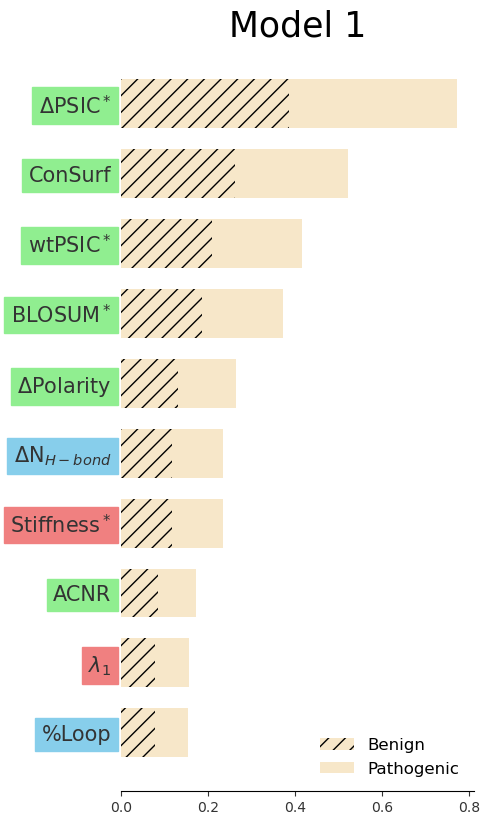

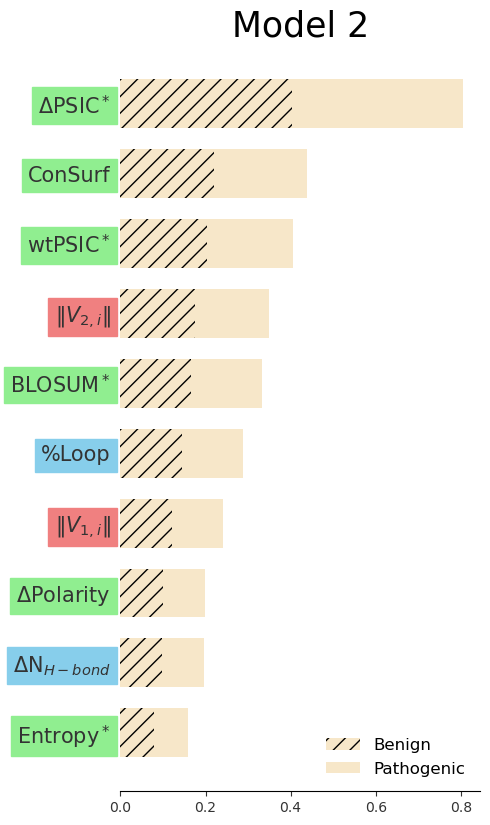

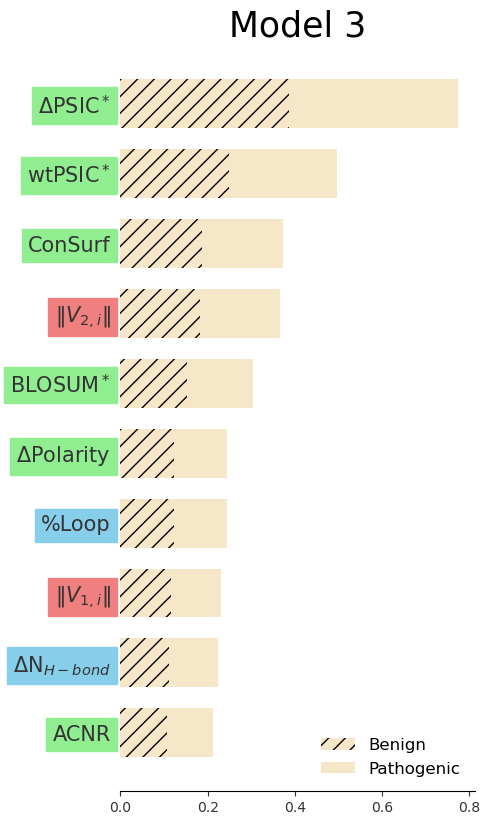

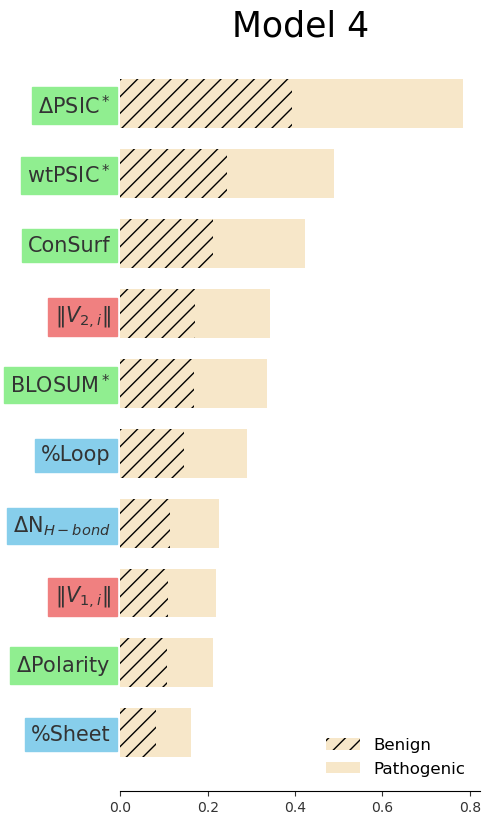

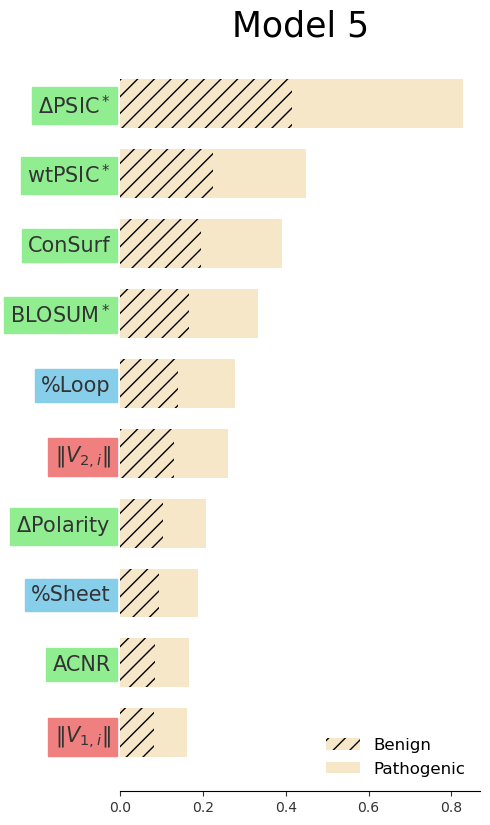

In [44]:
plot_figure_importance(shap_values_0, sel_feats, max_display=10, title='Model 1')
plot_figure_importance(shap_values_1, sel_feats, max_display=10, title='Model 2')
plot_figure_importance(shap_values_2, sel_feats, max_display=10, title='Model 3')
plot_figure_importance(shap_values_3, sel_feats, max_display=10, title='Model 4')
plot_figure_importance(shap_values_4, sel_feats, max_display=10, title='Model 5')

In [ ]:
plot_figure_importance(shap_values_1, f_names, max_display=10, title='Model 2')

## Feature interaction

In [32]:
# Plot feature interaction of the first model (split 1), 
# Show independence plot
shap.dependence_plot(ind='ACNR', shap_values=shap_values_0, features=x_test, feature_names=f_names, display_features=x_test)


TypeError: The passed shap_values are a list not an array! If you have a list of explanations try passing shap_values[0] instead to explain the first output class of a multi-output model.

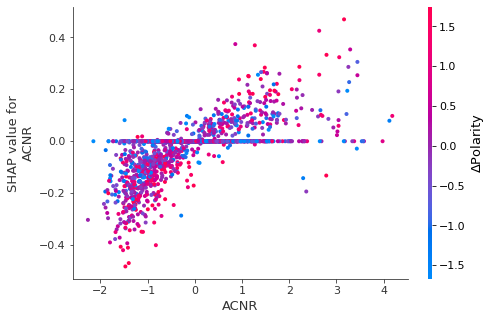

In [34]:
# Select SHAP values for the first output
shap_values_0_output = shap_values_0[0]

# Plot feature interaction for the 'ACNR' feature
shap.dependence_plot(ind='ACNR', shap_values=shap_values_0_output, features=x_test, feature_names=f_names, display_features=x_test)
